In [1]:
from argparse import ArgumentParser
import os
import sys
import random
import logging
import numpy as np

from scipy import integrate
from sklearn.metrics import mean_squared_error as MSE
import copy

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate

import torch
from torch.utils.data import DataLoader

In [2]:
from IPython.display import SVG, display
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

In [3]:
%cd drive/MyDrive/deep-stpp/notebooks

/content/drive/MyDrive/deep-stpp/notebooks


In [4]:
sys.path.append("/content/drive/MyDrive/deep-stpp/src")
from plotter import *
from model import DeepSTPP, log_ft, t_intensity, s_intensity
from data.dataset import SlidingWindowWrapper
from data.synthetic import *
from util import *

In [5]:
"""The code below is used to set up customized training device on computer"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("You are using GPU acceleration.")
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("CUDA is not Available. You are using CPU only.")
    print("Number of cores: ", os.cpu_count())

You are using GPU acceleration.
Device name:  Tesla P100-PCIE-16GB
Number of CUDAs(cores):  1


In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=False, decoder_n_layer=3)

In [7]:
"""
Prepare logger
"""
logger = logging.getLogger('full_lookahead{}batch{}'.format(config.lookahead, config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('full_lookahead{}batch{}.log'.format(config.lookahead, config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

## COVID NJ cases

In [10]:
dataset = 'covid_nj_cases'
npzf = np.load(f'../data/processed/{dataset}.npz', allow_pickle=True)

In [11]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)

In [12]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

In [19]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
print(scales)
print(biases)

[1.7725601 2.5865707 4.8739667]
[-7.5547775e+01  3.8723499e+01  6.6536053e-08]


### No sample

In [ ]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/no_sample/{dataset}_0.mod')

In [ ]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/no_sample/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:11:50,057 INFO In epochs 0 | total loss: -4.814151 | Space: 1.115223 | Time: 3.698927


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:12:06,507 INFO In epochs 1 | total loss: -4.912671 | Space: 1.196333 | Time: 3.716334


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:12:22,578 INFO In epochs 2 | total loss: -4.947520 | Space: 1.224844 | Time: 3.722672


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:12:38,664 INFO In epochs 3 | total loss: -4.967406 | Space: 1.241483 | Time: 3.725923


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:12:54,762 INFO In epochs 4 | total loss: -4.981115 | Space: 1.253030 | Time: 3.728084
2021-12-05 22:12:54,873 INFO Val Loss -3.937860 | Space: 1.127012 | Time: 2.810848


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:13:10,710 INFO In epochs 5 | total loss: -4.990504 | Space: 1.261050 | Time: 3.729449


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:13:26,991 INFO In epochs 6 | total loss: -4.997569 | Space: 1.267056 | Time: 3.730505


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:13:43,011 INFO In epochs 7 | total loss: -5.003129 | Space: 1.271774 | Time: 3.731349


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:13:59,020 INFO In epochs 8 | total loss: -5.007872 | Space: 1.275834 | Time: 3.732031


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:14:15,049 INFO In epochs 9 | total loss: -5.011956 | Space: 1.279325 | Time: 3.732625
2021-12-05 22:14:15,177 INFO Val Loss -3.987046 | Space: 1.145502 | Time: 2.841545


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:14:31,312 INFO In epochs 10 | total loss: -5.015336 | Space: 1.282236 | Time: 3.733091


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:14:47,456 INFO In epochs 11 | total loss: -5.018338 | Space: 1.284822 | Time: 3.733509


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:15:03,729 INFO In epochs 12 | total loss: -5.021100 | Space: 1.287204 | Time: 3.733888


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:15:19,921 INFO In epochs 13 | total loss: -5.023567 | Space: 1.289319 | Time: 3.734244


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:15:36,101 INFO In epochs 14 | total loss: -5.025724 | Space: 1.291172 | Time: 3.734542
2021-12-05 22:15:36,229 INFO Val Loss -4.002637 | Space: 1.165441 | Time: 2.837196


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:15:52,638 INFO In epochs 15 | total loss: -5.027679 | Space: 1.292863 | Time: 3.734804


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:16:08,932 INFO In epochs 16 | total loss: -5.029447 | Space: 1.294387 | Time: 3.735049


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:16:25,018 INFO In epochs 17 | total loss: -5.031045 | Space: 1.295764 | Time: 3.735273


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:16:40,930 INFO In epochs 18 | total loss: -5.032490 | Space: 1.297018 | Time: 3.735467


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:16:57,122 INFO In epochs 19 | total loss: -5.033888 | Space: 1.298224 | Time: 3.735663
2021-12-05 22:16:57,244 INFO Val Loss -3.985059 | Space: 1.160692 | Time: 2.824367


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:17:13,210 INFO In epochs 20 | total loss: -5.035197 | Space: 1.299352 | Time: 3.735844


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:17:29,371 INFO In epochs 21 | total loss: -5.036417 | Space: 1.300411 | Time: 3.736006


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:17:45,547 INFO In epochs 22 | total loss: -5.037555 | Space: 1.301387 | Time: 3.736172


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:18:01,495 INFO In epochs 23 | total loss: -5.038635 | Space: 1.302311 | Time: 3.736332


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:18:17,597 INFO In epochs 24 | total loss: -5.039643 | Space: 1.303181 | Time: 3.736467
2021-12-05 22:18:17,718 INFO Val Loss -4.002686 | Space: 1.153117 | Time: 2.849570


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:18:33,820 INFO In epochs 25 | total loss: -5.040630 | Space: 1.304030 | Time: 3.736600


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:18:50,195 INFO In epochs 26 | total loss: -5.041591 | Space: 1.304856 | Time: 3.736737


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:19:06,344 INFO In epochs 27 | total loss: -5.042513 | Space: 1.305643 | Time: 3.736876


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:19:22,221 INFO In epochs 28 | total loss: -5.043401 | Space: 1.306400 | Time: 3.737006


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:19:38,186 INFO In epochs 29 | total loss: -5.044275 | Space: 1.307136 | Time: 3.737141
2021-12-05 22:19:38,305 INFO Val Loss -4.004050 | Space: 1.169083 | Time: 2.834967


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:19:54,273 INFO In epochs 30 | total loss: -5.045119 | Space: 1.307848 | Time: 3.737274


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [ ]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/no_sample/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:20:26,208 INFO In epochs 0 | total loss: -4.778319 | Space: 1.074770 | Time: 3.703548


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:20:41,610 INFO In epochs 1 | total loss: -4.886822 | Space: 1.167448 | Time: 3.719373


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:20:57,378 INFO In epochs 2 | total loss: -4.931952 | Space: 1.207150 | Time: 3.724802


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:21:12,806 INFO In epochs 3 | total loss: -4.957349 | Space: 1.229749 | Time: 3.727601


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:21:28,479 INFO In epochs 4 | total loss: -4.973394 | Space: 1.243912 | Time: 3.729483
2021-12-05 22:21:28,589 INFO Val Loss -3.960939 | Space: 1.140279 | Time: 2.820661


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:21:44,309 INFO In epochs 5 | total loss: -4.984415 | Space: 1.253670 | Time: 3.730747


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:22:00,522 INFO In epochs 6 | total loss: -4.992472 | Space: 1.260819 | Time: 3.731657


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:22:16,763 INFO In epochs 7 | total loss: -4.998778 | Space: 1.266357 | Time: 3.732427


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:22:32,996 INFO In epochs 8 | total loss: -5.003751 | Space: 1.270744 | Time: 3.733014


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:22:49,442 INFO In epochs 9 | total loss: -5.007808 | Space: 1.274274 | Time: 3.733541
2021-12-05 22:22:49,567 INFO Val Loss -3.981352 | Space: 1.136742 | Time: 2.844610


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:23:06,035 INFO In epochs 10 | total loss: -5.011152 | Space: 1.277200 | Time: 3.733965


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:23:22,417 INFO In epochs 11 | total loss: -5.014057 | Space: 1.279689 | Time: 3.734378


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:23:38,726 INFO In epochs 12 | total loss: -5.016508 | Space: 1.281824 | Time: 3.734698


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:23:55,023 INFO In epochs 13 | total loss: -5.018625 | Space: 1.283654 | Time: 3.734985


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:24:11,620 INFO In epochs 14 | total loss: -5.020505 | Space: 1.285270 | Time: 3.735250
2021-12-05 22:24:11,741 INFO Val Loss -3.983101 | Space: 1.143183 | Time: 2.839918


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:24:28,052 INFO In epochs 15 | total loss: -5.022270 | Space: 1.286801 | Time: 3.735478


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:24:44,504 INFO In epochs 16 | total loss: -5.023922 | Space: 1.288232 | Time: 3.735695


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:25:00,916 INFO In epochs 17 | total loss: -5.025456 | Space: 1.289553 | Time: 3.735906


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:25:17,076 INFO In epochs 18 | total loss: -5.026813 | Space: 1.290752 | Time: 3.736064


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:25:33,555 INFO In epochs 19 | total loss: -5.028107 | Space: 1.291865 | Time: 3.736246
2021-12-05 22:25:33,762 INFO Val Loss -3.971317 | Space: 1.135452 | Time: 2.835865


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:25:49,997 INFO In epochs 20 | total loss: -5.029366 | Space: 1.292942 | Time: 3.736428


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:26:06,415 INFO In epochs 21 | total loss: -5.030561 | Space: 1.293981 | Time: 3.736585


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:26:22,392 INFO In epochs 22 | total loss: -5.031678 | Space: 1.294939 | Time: 3.736750


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:26:38,577 INFO In epochs 23 | total loss: -5.032718 | Space: 1.295836 | Time: 3.736891


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 22:26:54,896 INFO In epochs 24 | total loss: -5.033730 | Space: 1.296696 | Time: 3.737042
2021-12-05 22:26:55,021 INFO Val Loss -3.976398 | Space: 1.134799 | Time: 2.841599


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [17]:
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/no_sample/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-0.0787 ± 0.0214
2.4591 ± 0.0053


### Shared Decoders

In [14]:
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=2)

In [15]:
from ablation.model_shared import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/shared/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:45:47,923 INFO In epochs 0 | total loss: 0.219318 | Space: 0.872737 | Time: 3.605086


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:46:02,712 INFO In epochs 1 | total loss: 0.107389 | Space: 1.072773 | Time: 3.640747


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:46:16,899 INFO In epochs 2 | total loss: 0.070054 | Space: 1.143381 | Time: 3.652558


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:46:30,869 INFO In epochs 3 | total loss: 0.051377 | Space: 1.179229 | Time: 3.658662


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:46:45,109 INFO In epochs 4 | total loss: 0.040164 | Space: 1.201133 | Time: 3.662353
2021-12-07 06:46:45,230 INFO Val Loss -0.003535 | Space: 1.199565 | Time: 2.673406


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:46:59,539 INFO In epochs 5 | total loss: 0.032685 | Space: 1.215980 | Time: 3.664842


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:47:13,583 INFO In epochs 6 | total loss: 0.027342 | Space: 1.226752 | Time: 3.666634


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:47:28,169 INFO In epochs 7 | total loss: 0.023331 | Space: 1.234933 | Time: 3.667989


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:47:42,415 INFO In epochs 8 | total loss: 0.020211 | Space: 1.241338 | Time: 3.669116


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:47:56,897 INFO In epochs 9 | total loss: 0.017713 | Space: 1.246594 | Time: 3.669976
2021-12-07 06:47:57,050 INFO Val Loss -0.003700 | Space: 1.208071 | Time: 2.681702


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:48:11,355 INFO In epochs 10 | total loss: 0.015668 | Space: 1.250963 | Time: 3.670670


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:48:25,786 INFO In epochs 11 | total loss: 0.013964 | Space: 1.254603 | Time: 3.671305


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:48:40,352 INFO In epochs 12 | total loss: 0.012520 | Space: 1.257766 | Time: 3.671827


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:48:54,745 INFO In epochs 13 | total loss: 0.011283 | Space: 1.260521 | Time: 3.672241


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:49:09,126 INFO In epochs 14 | total loss: 0.010210 | Space: 1.262880 | Time: 3.672632


Evaluate


2021-12-07 06:49:09,344 INFO Val Loss -0.003750 | Space: 1.214773 | Time: 2.690813


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:49:23,692 INFO In epochs 15 | total loss: 0.009271 | Space: 1.264973 | Time: 3.672974


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:49:38,083 INFO In epochs 16 | total loss: 0.008441 | Space: 1.266818 | Time: 3.673282


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:49:52,459 INFO In epochs 17 | total loss: 0.007704 | Space: 1.268439 | Time: 3.673578


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:50:06,789 INFO In epochs 18 | total loss: 0.007044 | Space: 1.269969 | Time: 3.673784


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:50:20,936 INFO In epochs 19 | total loss: 0.006450 | Space: 1.271296 | Time: 3.674029
2021-12-07 06:50:21,053 INFO Val Loss -0.003712 | Space: 1.206996 | Time: 2.679803


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:50:35,076 INFO In epochs 20 | total loss: 0.005912 | Space: 1.272519 | Time: 3.674236


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:50:49,656 INFO In epochs 21 | total loss: 0.005423 | Space: 1.273631 | Time: 3.674423


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:51:04,421 INFO In epochs 22 | total loss: 0.004976 | Space: 1.274639 | Time: 3.674602


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:51:18,901 INFO In epochs 23 | total loss: 0.004566 | Space: 1.275560 | Time: 3.674769


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:51:33,525 INFO In epochs 24 | total loss: 0.004189 | Space: 1.276430 | Time: 3.674923
2021-12-07 06:51:33,655 INFO Val Loss -0.003389 | Space: 1.199378 | Time: 2.674988


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:51:48,320 INFO In epochs 25 | total loss: 0.003841 | Space: 1.277250 | Time: 3.675063


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:52:02,546 INFO In epochs 26 | total loss: 0.003519 | Space: 1.278024 | Time: 3.675179


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:52:16,849 INFO In epochs 27 | total loss: 0.003219 | Space: 1.278751 | Time: 3.675289


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:52:31,219 INFO In epochs 28 | total loss: 0.002940 | Space: 1.279425 | Time: 3.675393


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:52:45,511 INFO In epochs 29 | total loss: 0.002680 | Space: 1.280058 | Time: 3.675495
2021-12-07 06:52:45,631 INFO Val Loss -0.003859 | Space: 1.205914 | Time: 2.676758


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:52:59,952 INFO In epochs 30 | total loss: 0.002436 | Space: 1.280655 | Time: 3.675587


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:53:14,241 INFO In epochs 31 | total loss: 0.002207 | Space: 1.281212 | Time: 3.675673


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:53:28,223 INFO In epochs 32 | total loss: 0.001992 | Space: 1.281749 | Time: 3.675749


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:53:42,741 INFO In epochs 33 | total loss: 0.001790 | Space: 1.282253 | Time: 3.675819


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:53:57,063 INFO In epochs 34 | total loss: 0.001600 | Space: 1.282722 | Time: 3.675895
2021-12-07 06:53:57,183 INFO Val Loss -0.003812 | Space: 1.205651 | Time: 2.677691


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:54:11,425 INFO In epochs 35 | total loss: 0.001419 | Space: 1.283181 | Time: 3.675956


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:54:25,595 INFO In epochs 36 | total loss: 0.001249 | Space: 1.283619 | Time: 3.676012


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:54:39,987 INFO In epochs 37 | total loss: 0.001087 | Space: 1.284011 | Time: 3.676083


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:54:54,348 INFO In epochs 38 | total loss: 0.000934 | Space: 1.284399 | Time: 3.676136


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:55:08,801 INFO In epochs 39 | total loss: 0.000788 | Space: 1.284762 | Time: 3.676197
2021-12-07 06:55:08,922 INFO Val Loss -0.003781 | Space: 1.218435 | Time: 2.684651


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:55:23,210 INFO In epochs 40 | total loss: 0.000650 | Space: 1.285106 | Time: 3.676250


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:55:38,162 INFO In epochs 41 | total loss: 0.000518 | Space: 1.285445 | Time: 3.676289


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:55:53,210 INFO In epochs 42 | total loss: 0.000392 | Space: 1.285766 | Time: 3.676337


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:56:08,066 INFO In epochs 43 | total loss: 0.000272 | Space: 1.286073 | Time: 3.676378


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:56:22,957 INFO In epochs 44 | total loss: 0.000157 | Space: 1.286369 | Time: 3.676414
2021-12-07 06:56:23,085 INFO Val Loss -0.003768 | Space: 1.207217 | Time: 2.684116


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:56:37,905 INFO In epochs 45 | total loss: 0.000047 | Space: 1.286652 | Time: 3.676449


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:56:52,535 INFO In epochs 46 | total loss: -0.000059 | Space: 1.286923 | Time: 3.676482


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:57:07,195 INFO In epochs 47 | total loss: -0.000160 | Space: 1.287178 | Time: 3.676524


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:57:22,162 INFO In epochs 48 | total loss: -0.000257 | Space: 1.287439 | Time: 3.676557


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:57:36,607 INFO In epochs 49 | total loss: -0.000350 | Space: 1.287677 | Time: 3.676590
2021-12-07 06:57:36,742 INFO Val Loss -0.003865 | Space: 1.210219 | Time: 2.680444


Evaluate
training done!


In [16]:
from ablation.model_shared import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/shared/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:57:56,940 INFO In epochs 0 | total loss: 0.230794 | Space: 0.790369 | Time: 3.614801


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:58:11,120 INFO In epochs 1 | total loss: 0.113136 | Space: 0.998677 | Time: 3.652962


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:58:25,697 INFO In epochs 2 | total loss: 0.073891 | Space: 1.074573 | Time: 3.664622


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:58:39,949 INFO In epochs 3 | total loss: 0.054260 | Space: 1.114109 | Time: 3.670278


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:58:54,433 INFO In epochs 4 | total loss: 0.042478 | Space: 1.138542 | Time: 3.673647
2021-12-07 06:58:54,555 INFO Val Loss -0.003418 | Space: 1.166556 | Time: 2.714949


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:59:08,884 INFO In epochs 5 | total loss: 0.034619 | Space: 1.155293 | Time: 3.675939


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:59:23,265 INFO In epochs 6 | total loss: 0.029002 | Space: 1.167617 | Time: 3.677570


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:59:37,648 INFO In epochs 7 | total loss: 0.024788 | Space: 1.177008 | Time: 3.678753


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 06:59:52,146 INFO In epochs 8 | total loss: 0.021508 | Space: 1.184568 | Time: 3.679722


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:00:06,708 INFO In epochs 9 | total loss: 0.018884 | Space: 1.190719 | Time: 3.680433
2021-12-07 07:00:06,834 INFO Val Loss -0.003791 | Space: 1.180121 | Time: 2.715170


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:00:21,408 INFO In epochs 10 | total loss: 0.016735 | Space: 1.195843 | Time: 3.681051


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:00:36,027 INFO In epochs 11 | total loss: 0.014944 | Space: 1.200229 | Time: 3.681544


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:00:50,614 INFO In epochs 12 | total loss: 0.013428 | Space: 1.204021 | Time: 3.681961


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:01:04,974 INFO In epochs 13 | total loss: 0.012127 | Space: 1.207303 | Time: 3.682312


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:01:19,467 INFO In epochs 14 | total loss: 0.011000 | Space: 1.210152 | Time: 3.682638
2021-12-07 07:01:19,585 INFO Val Loss -0.003606 | Space: 1.171070 | Time: 2.711377


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:01:34,130 INFO In epochs 15 | total loss: 0.010013 | Space: 1.212700 | Time: 3.682887


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:01:48,662 INFO In epochs 16 | total loss: 0.009142 | Space: 1.214965 | Time: 3.683115


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:02:03,115 INFO In epochs 17 | total loss: 0.008367 | Space: 1.217022 | Time: 3.683299


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:02:17,668 INFO In epochs 18 | total loss: 0.007674 | Space: 1.218848 | Time: 3.683489


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:02:32,207 INFO In epochs 19 | total loss: 0.007050 | Space: 1.220558 | Time: 3.683636
2021-12-07 07:02:32,327 INFO Val Loss -0.003802 | Space: 1.172155 | Time: 2.709996


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:02:46,607 INFO In epochs 20 | total loss: 0.006484 | Space: 1.222103 | Time: 3.683791


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:03:00,866 INFO In epochs 21 | total loss: 0.005971 | Space: 1.223549 | Time: 3.683902


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:03:15,152 INFO In epochs 22 | total loss: 0.005501 | Space: 1.224879 | Time: 3.684031


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:03:29,372 INFO In epochs 23 | total loss: 0.005071 | Space: 1.226125 | Time: 3.684139


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:03:43,699 INFO In epochs 24 | total loss: 0.004675 | Space: 1.227270 | Time: 3.684241
2021-12-07 07:03:43,819 INFO Val Loss -0.003789 | Space: 1.179020 | Time: 2.714561


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:03:58,154 INFO In epochs 25 | total loss: 0.004309 | Space: 1.228307 | Time: 3.684363


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:04:12,528 INFO In epochs 26 | total loss: 0.003970 | Space: 1.229293 | Time: 3.684458


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:04:27,239 INFO In epochs 27 | total loss: 0.003655 | Space: 1.230231 | Time: 3.684537


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:04:41,717 INFO In epochs 28 | total loss: 0.003362 | Space: 1.231089 | Time: 3.684633


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:04:55,994 INFO In epochs 29 | total loss: 0.003088 | Space: 1.231902 | Time: 3.684718
2021-12-07 07:04:56,121 INFO Val Loss -0.003645 | Space: 1.190838 | Time: 2.715524


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:05:10,409 INFO In epochs 30 | total loss: 0.002832 | Space: 1.232672 | Time: 3.684785


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:05:24,868 INFO In epochs 31 | total loss: 0.002593 | Space: 1.233402 | Time: 3.684853


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:05:39,580 INFO In epochs 32 | total loss: 0.002367 | Space: 1.234088 | Time: 3.684925


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:05:54,221 INFO In epochs 33 | total loss: 0.002154 | Space: 1.234771 | Time: 3.684984


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:06:08,571 INFO In epochs 34 | total loss: 0.001954 | Space: 1.235470 | Time: 3.685030
2021-12-07 07:06:08,688 INFO Val Loss -0.003868 | Space: 1.181230 | Time: 2.705272


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:06:22,976 INFO In epochs 35 | total loss: 0.001764 | Space: 1.236143 | Time: 3.685083


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:06:37,678 INFO In epochs 36 | total loss: 0.001585 | Space: 1.236791 | Time: 3.685132


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:06:52,163 INFO In epochs 37 | total loss: 0.001415 | Space: 1.237427 | Time: 3.685167


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:07:06,528 INFO In epochs 38 | total loss: 0.001254 | Space: 1.238044 | Time: 3.685207


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:07:20,954 INFO In epochs 39 | total loss: 0.001101 | Space: 1.238707 | Time: 3.685233
2021-12-07 07:07:21,068 INFO Val Loss -0.003883 | Space: 1.176395 | Time: 2.706507


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:07:35,617 INFO In epochs 40 | total loss: 0.000955 | Space: 1.239536 | Time: 3.685246


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:07:50,336 INFO In epochs 41 | total loss: 0.000816 | Space: 1.240433 | Time: 3.685221


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:08:04,996 INFO In epochs 42 | total loss: 0.000683 | Space: 1.241298 | Time: 3.685190


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:08:19,666 INFO In epochs 43 | total loss: 0.000556 | Space: 1.242126 | Time: 3.685164


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:08:34,608 INFO In epochs 44 | total loss: 0.000435 | Space: 1.242927 | Time: 3.685140
2021-12-07 07:08:34,733 INFO Val Loss -0.003775 | Space: 1.182104 | Time: 2.702303


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:08:49,534 INFO In epochs 45 | total loss: 0.000320 | Space: 1.243695 | Time: 3.685113


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:09:04,337 INFO In epochs 46 | total loss: 0.000209 | Space: 1.244432 | Time: 3.685082


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:09:19,089 INFO In epochs 47 | total loss: 0.000102 | Space: 1.245136 | Time: 3.685064


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:09:33,978 INFO In epochs 48 | total loss: 0.000000 | Space: 1.245813 | Time: 3.685040


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:09:48,604 INFO In epochs 49 | total loss: -0.000098 | Space: 1.246462 | Time: 3.685024
2021-12-07 07:09:48,722 INFO Val Loss -0.003748 | Space: 1.172394 | Time: 2.703152


Evaluate
training done!


In [17]:
from ablation.model_shared import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/shared/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:10:08,631 INFO In epochs 0 | total loss: 0.219106 | Space: 0.861319 | Time: 3.608419


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:10:22,988 INFO In epochs 1 | total loss: 0.107282 | Space: 1.051703 | Time: 3.645890


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:10:37,378 INFO In epochs 2 | total loss: 0.069981 | Space: 1.121264 | Time: 3.658078


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:10:51,937 INFO In epochs 3 | total loss: 0.051320 | Space: 1.157335 | Time: 3.663919


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:11:06,500 INFO In epochs 4 | total loss: 0.040120 | Space: 1.179216 | Time: 3.667595
2021-12-07 07:11:06,617 INFO Val Loss -0.003490 | Space: 1.146806 | Time: 2.686703


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:11:21,089 INFO In epochs 5 | total loss: 0.032650 | Space: 1.193953 | Time: 3.670116


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:11:35,633 INFO In epochs 6 | total loss: 0.027311 | Space: 1.204807 | Time: 3.671911


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:11:50,316 INFO In epochs 7 | total loss: 0.023306 | Space: 1.213167 | Time: 3.673257


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:12:04,705 INFO In epochs 8 | total loss: 0.020189 | Space: 1.219751 | Time: 3.674260


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:12:18,910 INFO In epochs 9 | total loss: 0.017694 | Space: 1.225052 | Time: 3.675109
2021-12-07 07:12:19,027 INFO Val Loss -0.003536 | Space: 1.139950 | Time: 2.704047


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:12:33,345 INFO In epochs 10 | total loss: 0.015652 | Space: 1.229435 | Time: 3.675808


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:12:47,769 INFO In epochs 11 | total loss: 0.013950 | Space: 1.233102 | Time: 3.676392


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:13:02,098 INFO In epochs 12 | total loss: 0.012509 | Space: 1.236266 | Time: 3.676906


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:13:16,308 INFO In epochs 13 | total loss: 0.011273 | Space: 1.239085 | Time: 3.677317


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:13:30,669 INFO In epochs 14 | total loss: 0.010202 | Space: 1.241537 | Time: 3.677684
2021-12-07 07:13:30,785 INFO Val Loss -0.003442 | Space: 1.159202 | Time: 2.700979


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:13:45,158 INFO In epochs 15 | total loss: 0.009264 | Space: 1.243651 | Time: 3.678037


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:13:59,595 INFO In epochs 16 | total loss: 0.008436 | Space: 1.245616 | Time: 3.678299


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:14:13,704 INFO In epochs 17 | total loss: 0.007700 | Space: 1.247310 | Time: 3.678566


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:14:28,054 INFO In epochs 18 | total loss: 0.007041 | Space: 1.248873 | Time: 3.678770


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:14:42,350 INFO In epochs 19 | total loss: 0.006448 | Space: 1.250259 | Time: 3.678997
2021-12-07 07:14:42,474 INFO Val Loss -0.003755 | Space: 1.158232 | Time: 2.706347


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:14:56,924 INFO In epochs 20 | total loss: 0.005911 | Space: 1.251546 | Time: 3.679165


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:15:11,195 INFO In epochs 21 | total loss: 0.005422 | Space: 1.252717 | Time: 3.679341


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:15:25,545 INFO In epochs 22 | total loss: 0.004976 | Space: 1.253803 | Time: 3.679489


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:15:39,746 INFO In epochs 23 | total loss: 0.004567 | Space: 1.254791 | Time: 3.679626


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:15:54,275 INFO In epochs 24 | total loss: 0.004191 | Space: 1.255691 | Time: 3.679766
2021-12-07 07:15:54,384 INFO Val Loss -0.003826 | Space: 1.161357 | Time: 2.705618


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:16:08,757 INFO In epochs 25 | total loss: 0.003843 | Space: 1.256518 | Time: 3.679900


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:16:23,025 INFO In epochs 26 | total loss: 0.003521 | Space: 1.257306 | Time: 3.680011


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:16:37,385 INFO In epochs 27 | total loss: 0.003222 | Space: 1.258031 | Time: 3.680123


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:16:51,891 INFO In epochs 28 | total loss: 0.002944 | Space: 1.258709 | Time: 3.680230


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:17:06,276 INFO In epochs 29 | total loss: 0.002683 | Space: 1.259352 | Time: 3.680323
2021-12-07 07:17:06,392 INFO Val Loss -0.003847 | Space: 1.168588 | Time: 2.718853


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:17:20,746 INFO In epochs 30 | total loss: 0.002440 | Space: 1.259952 | Time: 3.680416


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:17:35,029 INFO In epochs 31 | total loss: 0.002212 | Space: 1.260516 | Time: 3.680499


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:17:49,245 INFO In epochs 32 | total loss: 0.001997 | Space: 1.261058 | Time: 3.680570


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:18:03,644 INFO In epochs 33 | total loss: 0.001796 | Space: 1.261565 | Time: 3.680647


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:18:17,929 INFO In epochs 34 | total loss: 0.001605 | Space: 1.262042 | Time: 3.680734
2021-12-07 07:18:18,046 INFO Val Loss -0.003737 | Space: 1.177249 | Time: 2.703426


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:18:32,534 INFO In epochs 35 | total loss: 0.001425 | Space: 1.262492 | Time: 3.680811


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:18:47,114 INFO In epochs 36 | total loss: 0.001255 | Space: 1.262934 | Time: 3.680863


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:19:01,447 INFO In epochs 37 | total loss: 0.001094 | Space: 1.263345 | Time: 3.680925


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:19:15,802 INFO In epochs 38 | total loss: 0.000941 | Space: 1.263739 | Time: 3.680981


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:19:30,229 INFO In epochs 39 | total loss: 0.000795 | Space: 1.264118 | Time: 3.681032
2021-12-07 07:19:30,347 INFO Val Loss -0.003823 | Space: 1.169083 | Time: 2.700508


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:19:44,852 INFO In epochs 40 | total loss: 0.000657 | Space: 1.264475 | Time: 3.681087


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:19:59,368 INFO In epochs 41 | total loss: 0.000525 | Space: 1.264807 | Time: 3.681145


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:20:13,675 INFO In epochs 42 | total loss: 0.000399 | Space: 1.265131 | Time: 3.681190


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:20:28,131 INFO In epochs 43 | total loss: 0.000279 | Space: 1.265436 | Time: 3.681235


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:20:42,651 INFO In epochs 44 | total loss: 0.000164 | Space: 1.265731 | Time: 3.681282
2021-12-07 07:20:42,773 INFO Val Loss -0.003810 | Space: 1.172067 | Time: 2.697155


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:20:57,789 INFO In epochs 45 | total loss: 0.000055 | Space: 1.266027 | Time: 3.681315


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:21:12,554 INFO In epochs 46 | total loss: -0.000051 | Space: 1.266298 | Time: 3.681358


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:21:27,325 INFO In epochs 47 | total loss: -0.000151 | Space: 1.266558 | Time: 3.681400


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:21:42,162 INFO In epochs 48 | total loss: -0.000248 | Space: 1.266807 | Time: 3.681434


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-07 07:21:56,957 INFO In epochs 49 | total loss: -0.000341 | Space: 1.267051 | Time: 3.681467
2021-12-07 07:21:57,093 INFO Val Loss -0.003663 | Space: 1.164495 | Time: 2.703447


Evaluate
training done!


In [24]:
from ablation.model_shared import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/shared/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-0.1152 ± 0.0142
2.4581 ± 0.0030


### Separate Encoders

In [25]:
config.epochs=30

In [ ]:
from ablation.model_sepenc import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/sepenc/{dataset}_0.mod')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:34:51,950 INFO In epochs 0 | total loss: -4.824185 | Space: 1.117323 | Time: 3.706863


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:35:44,804 INFO In epochs 1 | total loss: -4.926863 | Space: 1.206018 | Time: 3.720846


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:36:37,752 INFO In epochs 2 | total loss: -4.965477 | Space: 1.239787 | Time: 3.725692


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:37:31,096 INFO In epochs 3 | total loss: -4.986289 | Space: 1.258013 | Time: 3.728279


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:38:23,361 INFO In epochs 4 | total loss: -4.999131 | Space: 1.269155 | Time: 3.729980


Evaluate


2021-12-06 08:38:23,704 INFO Val Loss -3.991358 | Space: 1.172859 | Time: 2.818499


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:39:18,982 INFO In epochs 5 | total loss: -5.008035 | Space: 1.276846 | Time: 3.731193


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:40:14,173 INFO In epochs 6 | total loss: -5.014498 | Space: 1.282422 | Time: 3.732088


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:41:08,338 INFO In epochs 7 | total loss: -5.019473 | Space: 1.286713 | Time: 3.732772


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:42:03,963 INFO In epochs 8 | total loss: -5.023394 | Space: 1.290075 | Time: 3.733330


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:42:56,995 INFO In epochs 9 | total loss: -5.026683 | Space: 1.292875 | Time: 3.733814


Evaluate


2021-12-06 08:42:57,391 INFO Val Loss -3.959989 | Space: 1.177327 | Time: 2.782662


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:43:54,054 INFO In epochs 10 | total loss: -5.029352 | Space: 1.295190 | Time: 3.734169


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:44:47,712 INFO In epochs 11 | total loss: -5.031615 | Space: 1.297125 | Time: 3.734498


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:45:42,049 INFO In epochs 12 | total loss: -5.033575 | Space: 1.298796 | Time: 3.734782


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:46:37,267 INFO In epochs 13 | total loss: -5.035298 | Space: 1.300252 | Time: 3.735048


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:47:32,182 INFO In epochs 14 | total loss: -5.036860 | Space: 1.301544 | Time: 3.735320


Evaluate


2021-12-06 08:47:32,537 INFO Val Loss -4.005296 | Space: 1.149613 | Time: 2.855682


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:48:26,620 INFO In epochs 15 | total loss: -5.038231 | Space: 1.302669 | Time: 3.735564


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:49:19,953 INFO In epochs 16 | total loss: -5.039448 | Space: 1.303683 | Time: 3.735767


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:50:14,862 INFO In epochs 17 | total loss: -5.040653 | Space: 1.304719 | Time: 3.735939


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:51:08,262 INFO In epochs 18 | total loss: -5.041824 | Space: 1.305717 | Time: 3.736111


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:52:01,188 INFO In epochs 19 | total loss: -5.042909 | Space: 1.306630 | Time: 3.736283


Evaluate


2021-12-06 08:52:01,553 INFO Val Loss -4.010729 | Space: 1.159208 | Time: 2.851522


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:52:55,126 INFO In epochs 20 | total loss: -5.043951 | Space: 1.307508 | Time: 3.736442


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:53:49,951 INFO In epochs 21 | total loss: -5.044891 | Space: 1.308305 | Time: 3.736586


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:54:43,804 INFO In epochs 22 | total loss: -5.045773 | Space: 1.309038 | Time: 3.736738


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:55:38,354 INFO In epochs 23 | total loss: -5.046590 | Space: 1.309729 | Time: 3.736862


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:56:33,058 INFO In epochs 24 | total loss: -5.047363 | Space: 1.310376 | Time: 3.736987


Evaluate


2021-12-06 08:56:33,386 INFO Val Loss -3.971795 | Space: 1.148538 | Time: 2.823257


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:57:25,392 INFO In epochs 25 | total loss: -5.048099 | Space: 1.310994 | Time: 3.737106


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:58:18,720 INFO In epochs 26 | total loss: -5.048804 | Space: 1.311584 | Time: 3.737222


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 08:59:11,344 INFO In epochs 27 | total loss: -5.049458 | Space: 1.312126 | Time: 3.737334


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 09:00:03,797 INFO In epochs 28 | total loss: -5.050090 | Space: 1.312649 | Time: 3.737451


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 09:00:56,510 INFO In epochs 29 | total loss: -5.050696 | Space: 1.313138 | Time: 3.737563


Evaluate


2021-12-06 09:00:56,846 INFO Val Loss -3.964751 | Space: 1.123845 | Time: 2.840905


training done!


In [ ]:
from ablation.model_sepenc import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/sepenc/{dataset}_1.mod')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:55:35,397 INFO In epochs 0 | total loss: 0.632586 | Space: 0.841683 | Time: 3.604650


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:56:11,298 INFO In epochs 1 | total loss: 0.314372 | Space: 1.037502 | Time: 3.642741


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:56:46,904 INFO In epochs 2 | total loss: 0.208245 | Space: 1.111489 | Time: 3.654931


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:57:22,328 INFO In epochs 3 | total loss: 0.155156 | Space: 1.149623 | Time: 3.661191


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:57:57,906 INFO In epochs 4 | total loss: 0.123290 | Space: 1.173234 | Time: 3.664975


Evaluate


2021-12-06 02:57:58,195 INFO Val Loss -0.002754 | Space: 1.182404 | Time: 2.695859


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:58:34,633 INFO In epochs 5 | total loss: 0.102039 | Space: 1.189340 | Time: 3.667529


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:59:10,268 INFO In epochs 6 | total loss: 0.086851 | Space: 1.201126 | Time: 3.669382


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 02:59:45,555 INFO In epochs 7 | total loss: 0.075456 | Space: 1.210031 | Time: 3.670827


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:00:20,991 INFO In epochs 8 | total loss: 0.066593 | Space: 1.217088 | Time: 3.671964


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:00:56,309 INFO In epochs 9 | total loss: 0.059494 | Space: 1.222816 | Time: 3.672868


Evaluate


2021-12-06 03:00:56,573 INFO Val Loss -0.003140 | Space: 1.188162 | Time: 2.690810


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:01:31,843 INFO In epochs 10 | total loss: 0.053686 | Space: 1.227535 | Time: 3.673635


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:02:07,151 INFO In epochs 11 | total loss: 0.048843 | Space: 1.231476 | Time: 3.674253


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:02:42,406 INFO In epochs 12 | total loss: 0.044743 | Space: 1.234864 | Time: 3.674817


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:03:19,926 INFO In epochs 13 | total loss: 0.041229 | Space: 1.237787 | Time: 3.675292


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:03:56,588 INFO In epochs 14 | total loss: 0.038182 | Space: 1.240399 | Time: 3.675661


Evaluate


2021-12-06 03:03:56,855 INFO Val Loss -0.003828 | Space: 1.200882 | Time: 2.704436


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:04:33,197 INFO In epochs 15 | total loss: 0.035514 | Space: 1.242663 | Time: 3.676022


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:05:08,785 INFO In epochs 16 | total loss: 0.033159 | Space: 1.244686 | Time: 3.676343


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [ ]:
from ablation.model_sepenc import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/sepenc/{dataset}_2.mod')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:06:19,145 INFO In epochs 0 | total loss: 0.695137 | Space: 0.884266 | Time: 3.600138


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:06:53,852 INFO In epochs 1 | total loss: 0.345684 | Space: 1.070250 | Time: 3.638844


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:07:29,084 INFO In epochs 2 | total loss: 0.229140 | Space: 1.134564 | Time: 3.652373


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:08:04,226 INFO In epochs 3 | total loss: 0.170839 | Space: 1.167202 | Time: 3.659480


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:08:39,222 INFO In epochs 4 | total loss: 0.135845 | Space: 1.186954 | Time: 3.664037


Evaluate


2021-12-06 03:08:39,466 INFO Val Loss -0.003392 | Space: 1.161269 | Time: 2.700335


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:09:14,516 INFO In epochs 5 | total loss: 0.112507 | Space: 1.200358 | Time: 3.667055


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:09:49,493 INFO In epochs 6 | total loss: 0.095830 | Space: 1.209941 | Time: 3.669340


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:10:24,769 INFO In epochs 7 | total loss: 0.083318 | Space: 1.217230 | Time: 3.671069


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:11:00,121 INFO In epochs 8 | total loss: 0.073581 | Space: 1.222985 | Time: 3.672397


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:11:35,258 INFO In epochs 9 | total loss: 0.065789 | Space: 1.227682 | Time: 3.673518


Evaluate


2021-12-06 03:11:35,516 INFO Val Loss -0.003428 | Space: 1.166652 | Time: 2.712399


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:12:10,636 INFO In epochs 10 | total loss: 0.059410 | Space: 1.231689 | Time: 3.674389


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:12:45,864 INFO In epochs 11 | total loss: 0.054092 | Space: 1.234995 | Time: 3.675190


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:13:20,728 INFO In epochs 12 | total loss: 0.049591 | Space: 1.237813 | Time: 3.675879


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:13:55,551 INFO In epochs 13 | total loss: 0.045731 | Space: 1.240265 | Time: 3.676450


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:14:30,828 INFO In epochs 14 | total loss: 0.042385 | Space: 1.242401 | Time: 3.676958


Evaluate


2021-12-06 03:14:31,086 INFO Val Loss -0.003358 | Space: 1.161816 | Time: 2.703604


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:15:06,085 INFO In epochs 15 | total loss: 0.039455 | Space: 1.244264 | Time: 3.677416


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:15:41,430 INFO In epochs 16 | total loss: 0.036869 | Space: 1.245974 | Time: 3.677796


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:16:16,895 INFO In epochs 17 | total loss: 0.034570 | Space: 1.247466 | Time: 3.678161


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:16:54,251 INFO In epochs 18 | total loss: 0.032511 | Space: 1.248792 | Time: 3.678502


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:17:30,829 INFO In epochs 19 | total loss: 0.030659 | Space: 1.250003 | Time: 3.678802


Evaluate


2021-12-06 03:17:31,096 INFO Val Loss -0.003206 | Space: 1.171857 | Time: 2.703838


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:18:07,003 INFO In epochs 20 | total loss: 0.028981 | Space: 1.251126 | Time: 3.679078


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:18:42,307 INFO In epochs 21 | total loss: 0.027457 | Space: 1.252137 | Time: 3.679336


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:19:17,438 INFO In epochs 22 | total loss: 0.026064 | Space: 1.253082 | Time: 3.679556


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:19:52,542 INFO In epochs 23 | total loss: 0.024786 | Space: 1.253942 | Time: 3.679777


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:20:27,481 INFO In epochs 24 | total loss: 0.023611 | Space: 1.254742 | Time: 3.679977


Evaluate


2021-12-06 03:20:27,729 INFO Val Loss -0.003662 | Space: 1.173419 | Time: 2.695986


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:21:03,022 INFO In epochs 25 | total loss: 0.022526 | Space: 1.255497 | Time: 3.680163


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:21:37,868 INFO In epochs 26 | total loss: 0.021520 | Space: 1.256195 | Time: 3.680329


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:22:13,271 INFO In epochs 27 | total loss: 0.020586 | Space: 1.256847 | Time: 3.680498


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [26]:
from ablation.model_sepenc import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/sepenc/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-0.1057 ± 0.0140
2.4561 ± 0.0048


### LSTM

In [27]:
config.epochs=50

In [ ]:
from ablation.model_lstm import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/lstm/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:36:33,385 INFO In epochs 0 | total loss: 0.093151 | Space: 0.876148 | Time: 3.604443


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:36:45,301 INFO In epochs 1 | total loss: 0.044116 | Space: 1.057704 | Time: 3.643500


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:36:56,929 INFO In epochs 2 | total loss: 0.027771 | Space: 1.121711 | Time: 3.656243


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:37:08,770 INFO In epochs 3 | total loss: 0.019600 | Space: 1.154280 | Time: 3.662835


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:37:20,627 INFO In epochs 4 | total loss: 0.014698 | Space: 1.174070 | Time: 3.666934
2021-12-06 03:37:20,715 INFO Val Loss -0.003864 | Space: 1.167940 | Time: 2.714319


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:37:32,339 INFO In epochs 5 | total loss: 0.011430 | Space: 1.187591 | Time: 3.669854


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:37:43,626 INFO In epochs 6 | total loss: 0.009094 | Space: 1.197324 | Time: 3.671930


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:37:54,989 INFO In epochs 7 | total loss: 0.007343 | Space: 1.204745 | Time: 3.673517


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:38:06,377 INFO In epochs 8 | total loss: 0.005980 | Space: 1.210531 | Time: 3.674835


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:38:17,727 INFO In epochs 9 | total loss: 0.004890 | Space: 1.215462 | Time: 3.675840
2021-12-06 03:38:17,821 INFO Val Loss -0.003873 | Space: 1.164050 | Time: 2.708919


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:38:29,376 INFO In epochs 10 | total loss: 0.003997 | Space: 1.220086 | Time: 3.676605


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [ ]:
from ablation.model_lstm import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/lstm/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:39:07,683 INFO In epochs 0 | total loss: 0.098699 | Space: 0.872484 | Time: 3.599774


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:39:19,350 INFO In epochs 1 | total loss: 0.046889 | Space: 1.061581 | Time: 3.637566


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:39:30,866 INFO In epochs 2 | total loss: 0.029615 | Space: 1.130164 | Time: 3.650128


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:39:42,442 INFO In epochs 3 | total loss: 0.020979 | Space: 1.167401 | Time: 3.656430


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:39:54,041 INFO In epochs 4 | total loss: 0.015796 | Space: 1.190698 | Time: 3.660349
2021-12-06 03:39:54,124 INFO Val Loss -0.003853 | Space: 1.187034 | Time: 2.669086


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:40:05,652 INFO In epochs 5 | total loss: 0.012341 | Space: 1.206603 | Time: 3.662987


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:40:17,060 INFO In epochs 6 | total loss: 0.009872 | Space: 1.218220 | Time: 3.664901


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:40:28,379 INFO In epochs 7 | total loss: 0.008020 | Space: 1.227080 | Time: 3.666332


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:40:39,904 INFO In epochs 8 | total loss: 0.006579 | Space: 1.233958 | Time: 3.667550


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:40:51,412 INFO In epochs 9 | total loss: 0.005427 | Space: 1.239504 | Time: 3.668530
2021-12-06 03:40:51,501 INFO Val Loss -0.003845 | Space: 1.181577 | Time: 2.684042


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:41:03,402 INFO In epochs 10 | total loss: 0.004483 | Space: 1.244105 | Time: 3.669319


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [ ]:
from ablation.model_lstm import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/lstm/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:41:18,466 INFO In epochs 0 | total loss: 0.100486 | Space: 0.866178 | Time: 3.606176


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:41:30,046 INFO In epochs 1 | total loss: 0.047778 | Space: 1.060194 | Time: 3.641834


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:41:41,862 INFO In epochs 2 | total loss: 0.030207 | Space: 1.128816 | Time: 3.653797


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:41:53,424 INFO In epochs 3 | total loss: 0.021424 | Space: 1.163661 | Time: 3.660045


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:42:04,848 INFO In epochs 4 | total loss: 0.016154 | Space: 1.184823 | Time: 3.663775
2021-12-06 03:42:04,938 INFO Val Loss -0.003889 | Space: 1.191389 | Time: 2.706719


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:42:16,468 INFO In epochs 5 | total loss: 0.012640 | Space: 1.199031 | Time: 3.666472


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:42:28,048 INFO In epochs 6 | total loss: 0.010130 | Space: 1.209530 | Time: 3.668322


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:42:39,574 INFO In epochs 7 | total loss: 0.008247 | Space: 1.217675 | Time: 3.669715


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:42:51,037 INFO In epochs 8 | total loss: 0.006782 | Space: 1.224101 | Time: 3.670824


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:43:02,349 INFO In epochs 9 | total loss: 0.005610 | Space: 1.229372 | Time: 3.671708
2021-12-06 03:43:02,550 INFO Val Loss -0.003848 | Space: 1.189195 | Time: 2.687142


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-06 03:43:14,149 INFO In epochs 10 | total loss: 0.004651 | Space: 1.233724 | Time: 3.672451


  0%|          | 0/901 [00:00<?, ?it/s]

Numerical error, quiting...


In [29]:
from ablation.model_lstm import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/lstm/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-0.1162 ± 0.0102
2.4554 ± 0.0035


## STHP DS1



In [30]:
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-4, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b=False, sample=False, decoder_n_layer=3)

In [31]:
dataset = 'sthp1'
npzf = np.load(f'../data/processed/{dataset}.npz', allow_pickle=True)

In [32]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)

In [33]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

In [34]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
print(scales)
print(biases)

[16.066196 17.661226 57.15966 ]
[-8.373209e+00 -9.603919e+00  1.100000e-05]


### No sample

In [ ]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/no_sample/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:35,482 INFO In epochs 0 | total loss: -2.707125 | Space: -0.275698 | Time: 2.982824


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:36,465 INFO In epochs 1 | total loss: -4.400959 | Space: 1.304578 | Time: 3.096380


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:37,436 INFO In epochs 2 | total loss: -5.163421 | Space: 1.936712 | Time: 3.226710


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:38,431 INFO In epochs 3 | total loss: -5.577105 | Space: 2.266089 | Time: 3.311016


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:39,455 INFO In epochs 4 | total loss: -5.831160 | Space: 2.468931 | Time: 3.362230
2021-12-06 03:47:39,502 INFO Val Loss -5.949808 | Space: 3.035290 | Time: 2.914518


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:40,497 INFO In epochs 5 | total loss: -6.002491 | Space: 2.605554 | Time: 3.396938


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:41,504 INFO In epochs 6 | total loss: -6.123857 | Space: 2.702942 | Time: 3.420914


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:42,484 INFO In epochs 7 | total loss: -6.217569 | Space: 2.778045 | Time: 3.439523


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:43,442 INFO In epochs 8 | total loss: -6.289126 | Space: 2.836220 | Time: 3.452906


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:44,409 INFO In epochs 9 | total loss: -6.347341 | Space: 2.882792 | Time: 3.464549
2021-12-06 03:47:44,453 INFO Val Loss -5.967184 | Space: 3.031188 | Time: 2.935996


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:45,481 INFO In epochs 10 | total loss: -6.394936 | Space: 2.920882 | Time: 3.474052


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:46,457 INFO In epochs 11 | total loss: -6.434353 | Space: 2.953003 | Time: 3.481349


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:47,442 INFO In epochs 12 | total loss: -6.467691 | Space: 2.980303 | Time: 3.487388


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:48,414 INFO In epochs 13 | total loss: -6.497478 | Space: 3.004027 | Time: 3.493450


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:49,411 INFO In epochs 14 | total loss: -6.522589 | Space: 3.024464 | Time: 3.498123
2021-12-06 03:47:49,460 INFO Val Loss -5.957966 | Space: 3.027400 | Time: 2.930566


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:50,595 INFO In epochs 15 | total loss: -6.544859 | Space: 3.042186 | Time: 3.502671


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:51,600 INFO In epochs 16 | total loss: -6.563523 | Space: 3.057695 | Time: 3.505826


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:52,580 INFO In epochs 17 | total loss: -6.581168 | Space: 3.071698 | Time: 3.509470


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:53,580 INFO In epochs 18 | total loss: -6.596951 | Space: 3.084252 | Time: 3.512699


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:54,580 INFO In epochs 19 | total loss: -6.610849 | Space: 3.095615 | Time: 3.515236
2021-12-06 03:47:54,634 INFO Val Loss -5.961184 | Space: 3.050872 | Time: 2.910313


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:55,673 INFO In epochs 20 | total loss: -6.623547 | Space: 3.105957 | Time: 3.517593


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:56,643 INFO In epochs 21 | total loss: -6.635287 | Space: 3.115307 | Time: 3.519983


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:57,634 INFO In epochs 22 | total loss: -6.646045 | Space: 3.123989 | Time: 3.522057


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:58,693 INFO In epochs 23 | total loss: -6.655708 | Space: 3.132231 | Time: 3.523479


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:47:59,677 INFO In epochs 24 | total loss: -6.664425 | Space: 3.139362 | Time: 3.525064
2021-12-06 03:47:59,729 INFO Val Loss -5.967748 | Space: 3.035475 | Time: 2.932273


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:00,771 INFO In epochs 25 | total loss: -6.672296 | Space: 3.145970 | Time: 3.526328


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:01,752 INFO In epochs 26 | total loss: -6.679661 | Space: 3.151866 | Time: 3.527796


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:02,736 INFO In epochs 27 | total loss: -6.686890 | Space: 3.157496 | Time: 3.529397


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:03,707 INFO In epochs 28 | total loss: -6.693559 | Space: 3.162783 | Time: 3.530778


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:04,740 INFO In epochs 29 | total loss: -6.699826 | Space: 3.167732 | Time: 3.532095
2021-12-06 03:48:04,777 INFO Val Loss -5.934391 | Space: 2.994969 | Time: 2.939422


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:05,778 INFO In epochs 30 | total loss: -6.705285 | Space: 3.172065 | Time: 3.533223


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:06,748 INFO In epochs 31 | total loss: -6.710425 | Space: 3.176183 | Time: 3.534244


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:07,728 INFO In epochs 32 | total loss: -6.715373 | Space: 3.180380 | Time: 3.534994


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:08,717 INFO In epochs 33 | total loss: -6.720028 | Space: 3.184022 | Time: 3.536007


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:09,835 INFO In epochs 34 | total loss: -6.724351 | Space: 3.187624 | Time: 3.536728
2021-12-06 03:48:09,883 INFO Val Loss -5.973307 | Space: 3.034235 | Time: 2.939073


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:10,870 INFO In epochs 35 | total loss: -6.728814 | Space: 3.191255 | Time: 3.537562


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:11,856 INFO In epochs 36 | total loss: -6.733101 | Space: 3.194660 | Time: 3.538445


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:12,848 INFO In epochs 37 | total loss: -6.737304 | Space: 3.198004 | Time: 3.539302


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:13,863 INFO In epochs 38 | total loss: -6.741005 | Space: 3.200941 | Time: 3.540066


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:14,855 INFO In epochs 39 | total loss: -6.744222 | Space: 3.203633 | Time: 3.540593
2021-12-06 03:48:14,909 INFO Val Loss -5.958616 | Space: 3.010824 | Time: 2.947793


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:15,906 INFO In epochs 40 | total loss: -6.747316 | Space: 3.206048 | Time: 3.541272


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:16,904 INFO In epochs 41 | total loss: -6.750532 | Space: 3.208696 | Time: 3.541838


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:17,955 INFO In epochs 42 | total loss: -6.753783 | Space: 3.211206 | Time: 3.542579


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:18,945 INFO In epochs 43 | total loss: -6.756854 | Space: 3.213546 | Time: 3.543311


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:19,929 INFO In epochs 44 | total loss: -6.759608 | Space: 3.215804 | Time: 3.543808
2021-12-06 03:48:19,974 INFO Val Loss -5.961328 | Space: 3.027298 | Time: 2.934030


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:20,998 INFO In epochs 45 | total loss: -6.762533 | Space: 3.218064 | Time: 3.544472


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:22,008 INFO In epochs 46 | total loss: -6.765217 | Space: 3.220084 | Time: 3.545135


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:23,023 INFO In epochs 47 | total loss: -6.767895 | Space: 3.222267 | Time: 3.545630


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:24,027 INFO In epochs 48 | total loss: -6.770563 | Space: 3.224353 | Time: 3.546212


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:25,016 INFO In epochs 49 | total loss: -6.772854 | Space: 3.226188 | Time: 3.546669
2021-12-06 03:48:25,063 INFO Val Loss -5.963202 | Space: 3.018417 | Time: 2.944785


Evaluate
training done!


In [ ]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/no_sample/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:26,506 INFO In epochs 0 | total loss: -2.669447 | Space: -0.283064 | Time: 2.952511


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:27,473 INFO In epochs 1 | total loss: -4.331563 | Space: 1.297220 | Time: 3.034343


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:28,466 INFO In epochs 2 | total loss: -5.101995 | Space: 1.934307 | Time: 3.167690


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:29,597 INFO In epochs 3 | total loss: -5.536046 | Space: 2.270892 | Time: 3.265155


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:30,584 INFO In epochs 4 | total loss: -5.800619 | Space: 2.475404 | Time: 3.325216
2021-12-06 03:48:30,629 INFO Val Loss -5.979729 | Space: 3.062748 | Time: 2.916981


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:31,612 INFO In epochs 5 | total loss: -5.975172 | Space: 2.610274 | Time: 3.364898


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:32,573 INFO In epochs 6 | total loss: -6.102458 | Space: 2.707709 | Time: 3.394751


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:33,546 INFO In epochs 7 | total loss: -6.196142 | Space: 2.780226 | Time: 3.415918


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:34,498 INFO In epochs 8 | total loss: -6.270679 | Space: 2.837512 | Time: 3.433169


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:35,450 INFO In epochs 9 | total loss: -6.330281 | Space: 2.884475 | Time: 3.445809
2021-12-06 03:48:35,498 INFO Val Loss -5.967648 | Space: 3.044862 | Time: 2.922787


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:36,467 INFO In epochs 10 | total loss: -6.379418 | Space: 2.922395 | Time: 3.457025


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:37,445 INFO In epochs 11 | total loss: -6.420137 | Space: 2.953830 | Time: 3.466308


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:38,482 INFO In epochs 12 | total loss: -6.455465 | Space: 2.981245 | Time: 3.474220


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:39,453 INFO In epochs 13 | total loss: -6.484408 | Space: 3.004015 | Time: 3.480391


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:40,423 INFO In epochs 14 | total loss: -6.509311 | Space: 3.024008 | Time: 3.485301
2021-12-06 03:48:40,464 INFO Val Loss -5.947251 | Space: 2.993139 | Time: 2.954113


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:41,439 INFO In epochs 15 | total loss: -6.532376 | Space: 3.041943 | Time: 3.490432


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:42,412 INFO In epochs 16 | total loss: -6.552644 | Space: 3.057632 | Time: 3.495011


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:43,387 INFO In epochs 17 | total loss: -6.569765 | Space: 3.071153 | Time: 3.498613


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:44,359 INFO In epochs 18 | total loss: -6.585643 | Space: 3.083591 | Time: 3.502052


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:45,352 INFO In epochs 19 | total loss: -6.600015 | Space: 3.094849 | Time: 3.505167
2021-12-06 03:48:45,398 INFO Val Loss -5.963109 | Space: 3.032936 | Time: 2.930173


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:46,373 INFO In epochs 20 | total loss: -6.613188 | Space: 3.105141 | Time: 3.508047


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:47,485 INFO In epochs 21 | total loss: -6.625251 | Space: 3.114551 | Time: 3.510702


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:48,641 INFO In epochs 22 | total loss: -6.635452 | Space: 3.122532 | Time: 3.512923


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:49,654 INFO In epochs 23 | total loss: -6.645649 | Space: 3.130681 | Time: 3.514971


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:50,671 INFO In epochs 24 | total loss: -6.654871 | Space: 3.137764 | Time: 3.517110
2021-12-06 03:48:50,721 INFO Val Loss -5.970975 | Space: 3.028770 | Time: 2.942204


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:51,698 INFO In epochs 25 | total loss: -6.662870 | Space: 3.144122 | Time: 3.518751


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:52,676 INFO In epochs 26 | total loss: -6.670933 | Space: 3.150322 | Time: 3.520614


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:53,659 INFO In epochs 27 | total loss: -6.677992 | Space: 3.155858 | Time: 3.522138


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:54,641 INFO In epochs 28 | total loss: -6.684810 | Space: 3.161098 | Time: 3.523715


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:55,624 INFO In epochs 29 | total loss: -6.691193 | Space: 3.166033 | Time: 3.525163
2021-12-06 03:48:55,670 INFO Val Loss -5.923019 | Space: 2.983577 | Time: 2.939442


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:56,664 INFO In epochs 30 | total loss: -6.696720 | Space: 3.170330 | Time: 3.526392


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:57,649 INFO In epochs 31 | total loss: -6.702545 | Space: 3.174685 | Time: 3.527862


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:58,627 INFO In epochs 32 | total loss: -6.707736 | Space: 3.178672 | Time: 3.529066


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:48:59,623 INFO In epochs 33 | total loss: -6.712668 | Space: 3.182522 | Time: 3.530149


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:00,616 INFO In epochs 34 | total loss: -6.716737 | Space: 3.185795 | Time: 3.530946
2021-12-06 03:49:00,668 INFO Val Loss -5.961085 | Space: 3.015633 | Time: 2.945452


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:01,664 INFO In epochs 35 | total loss: -6.720958 | Space: 3.189029 | Time: 3.531934


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:02,643 INFO In epochs 36 | total loss: -6.725133 | Space: 3.192251 | Time: 3.532887


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:03,642 INFO In epochs 37 | total loss: -6.728842 | Space: 3.195056 | Time: 3.533792


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:04,617 INFO In epochs 38 | total loss: -6.732968 | Space: 3.198100 | Time: 3.534874


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:05,612 INFO In epochs 39 | total loss: -6.736093 | Space: 3.200490 | Time: 3.535609
2021-12-06 03:49:05,666 INFO Val Loss -5.965986 | Space: 3.033489 | Time: 2.932498


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:06,702 INFO In epochs 40 | total loss: -6.739723 | Space: 3.203147 | Time: 3.536581


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:07,699 INFO In epochs 41 | total loss: -6.743220 | Space: 3.205850 | Time: 3.537377


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:08,841 INFO In epochs 42 | total loss: -6.746174 | Space: 3.208245 | Time: 3.537933


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:09,879 INFO In epochs 43 | total loss: -6.749099 | Space: 3.210534 | Time: 3.538568


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:10,867 INFO In epochs 44 | total loss: -6.751792 | Space: 3.212717 | Time: 3.539078
2021-12-06 03:49:10,920 INFO Val Loss -5.939967 | Space: 3.015392 | Time: 2.924575


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:11,928 INFO In epochs 45 | total loss: -6.754410 | Space: 3.214671 | Time: 3.539742


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:13,016 INFO In epochs 46 | total loss: -6.756926 | Space: 3.216527 | Time: 3.540402


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:14,015 INFO In epochs 47 | total loss: -6.759540 | Space: 3.218567 | Time: 3.540977


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:15,056 INFO In epochs 48 | total loss: -6.762003 | Space: 3.220577 | Time: 3.541430


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:16,091 INFO In epochs 49 | total loss: -6.764305 | Space: 3.222326 | Time: 3.541983
2021-12-06 03:49:16,141 INFO Val Loss -5.946690 | Space: 3.007023 | Time: 2.939667


Evaluate
training done!


In [ ]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/no_sample/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:17,558 INFO In epochs 0 | total loss: -2.532669 | Space: -0.398421 | Time: 2.931090


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:18,584 INFO In epochs 1 | total loss: -4.251205 | Space: 1.221185 | Time: 3.030019


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:19,533 INFO In epochs 2 | total loss: -5.041156 | Space: 1.883565 | Time: 3.157593


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:20,524 INFO In epochs 3 | total loss: -5.487440 | Space: 2.232085 | Time: 3.255356


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:21,523 INFO In epochs 4 | total loss: -5.763194 | Space: 2.445652 | Time: 3.317544
2021-12-06 03:49:21,569 INFO Val Loss -5.971553 | Space: 3.045294 | Time: 2.926259


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:22,543 INFO In epochs 5 | total loss: -5.945498 | Space: 2.586695 | Time: 3.358804


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:23,505 INFO In epochs 6 | total loss: -6.076900 | Space: 2.689308 | Time: 3.387592


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:24,478 INFO In epochs 7 | total loss: -6.174220 | Space: 2.765415 | Time: 3.408805


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:25,484 INFO In epochs 8 | total loss: -6.251952 | Space: 2.825176 | Time: 3.426777


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:26,442 INFO In epochs 9 | total loss: -6.313583 | Space: 2.872374 | Time: 3.441209
2021-12-06 03:49:26,487 INFO Val Loss -5.946688 | Space: 3.021842 | Time: 2.924847


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:27,460 INFO In epochs 10 | total loss: -6.363892 | Space: 2.911490 | Time: 3.452401


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:28,438 INFO In epochs 11 | total loss: -6.403850 | Space: 2.943678 | Time: 3.460171


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:29,624 INFO In epochs 12 | total loss: -6.438837 | Space: 2.970443 | Time: 3.468391


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:30,608 INFO In epochs 13 | total loss: -6.470498 | Space: 2.994410 | Time: 3.476087


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:31,601 INFO In epochs 14 | total loss: -6.497650 | Space: 3.015634 | Time: 3.482013
2021-12-06 03:49:31,648 INFO Val Loss -5.976474 | Space: 3.038481 | Time: 2.937994


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:32,666 INFO In epochs 15 | total loss: -6.521564 | Space: 3.033769 | Time: 3.487791


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:33,645 INFO In epochs 16 | total loss: -6.541513 | Space: 3.049289 | Time: 3.492220


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:34,686 INFO In epochs 17 | total loss: -6.559998 | Space: 3.063526 | Time: 3.496469


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:35,663 INFO In epochs 18 | total loss: -6.576475 | Space: 3.076166 | Time: 3.500305


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:36,672 INFO In epochs 19 | total loss: -6.591736 | Space: 3.087789 | Time: 3.503943
2021-12-06 03:49:36,723 INFO Val Loss -5.962276 | Space: 3.018121 | Time: 2.944155


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:37,707 INFO In epochs 20 | total loss: -6.605018 | Space: 3.098089 | Time: 3.506924


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:38,690 INFO In epochs 21 | total loss: -6.616829 | Space: 3.107243 | Time: 3.509584


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:39,671 INFO In epochs 22 | total loss: -6.628195 | Space: 3.115838 | Time: 3.512356


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:40,654 INFO In epochs 23 | total loss: -6.638286 | Space: 3.123653 | Time: 3.514632


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:41,625 INFO In epochs 24 | total loss: -6.647876 | Space: 3.131190 | Time: 3.516684
2021-12-06 03:49:41,672 INFO Val Loss -5.952332 | Space: 3.041885 | Time: 2.910447


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:42,652 INFO In epochs 25 | total loss: -6.656988 | Space: 3.138055 | Time: 3.518933


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:43,659 INFO In epochs 26 | total loss: -6.665060 | Space: 3.143902 | Time: 3.521156


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:44,640 INFO In epochs 27 | total loss: -6.672633 | Space: 3.149918 | Time: 3.522714


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:45,615 INFO In epochs 28 | total loss: -6.679528 | Space: 3.155356 | Time: 3.524171


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:46,621 INFO In epochs 29 | total loss: -6.686063 | Space: 3.160472 | Time: 3.525591
2021-12-06 03:49:46,677 INFO Val Loss -5.934653 | Space: 3.005878 | Time: 2.928775


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:47,790 INFO In epochs 30 | total loss: -6.691998 | Space: 3.164943 | Time: 3.527054


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:48,777 INFO In epochs 31 | total loss: -6.697877 | Space: 3.169478 | Time: 3.528399


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:49,925 INFO In epochs 32 | total loss: -6.703321 | Space: 3.173572 | Time: 3.529750


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:50,983 INFO In epochs 33 | total loss: -6.708043 | Space: 3.177342 | Time: 3.530702


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:51,978 INFO In epochs 34 | total loss: -6.712683 | Space: 3.180990 | Time: 3.531697
2021-12-06 03:49:52,020 INFO Val Loss -5.951489 | Space: 3.010976 | Time: 2.940513


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:53,022 INFO In epochs 35 | total loss: -6.717180 | Space: 3.184669 | Time: 3.532514


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:54,018 INFO In epochs 36 | total loss: -6.721504 | Space: 3.187922 | Time: 3.533586


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:55,013 INFO In epochs 37 | total loss: -6.725556 | Space: 3.191196 | Time: 3.534361


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:55,996 INFO In epochs 38 | total loss: -6.729574 | Space: 3.194287 | Time: 3.535288


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:56,987 INFO In epochs 39 | total loss: -6.733342 | Space: 3.197338 | Time: 3.536007
2021-12-06 03:49:57,037 INFO Val Loss -5.959596 | Space: 3.025173 | Time: 2.934423


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:58,016 INFO In epochs 40 | total loss: -6.736839 | Space: 3.200210 | Time: 3.536631


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:49:59,028 INFO In epochs 41 | total loss: -6.740249 | Space: 3.202855 | Time: 3.537395


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:00,020 INFO In epochs 42 | total loss: -6.743178 | Space: 3.205181 | Time: 3.537998


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:01,022 INFO In epochs 43 | total loss: -6.745539 | Space: 3.207177 | Time: 3.538363


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:02,007 INFO In epochs 44 | total loss: -6.748638 | Space: 3.209694 | Time: 3.538944
2021-12-06 03:50:02,060 INFO Val Loss -5.925696 | Space: 2.985704 | Time: 2.939991


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:03,049 INFO In epochs 45 | total loss: -6.751361 | Space: 3.212049 | Time: 3.539312


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:04,044 INFO In epochs 46 | total loss: -6.754295 | Space: 3.214341 | Time: 3.539953


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:05,090 INFO In epochs 47 | total loss: -6.757262 | Space: 3.216544 | Time: 3.540718


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:06,110 INFO In epochs 48 | total loss: -6.759929 | Space: 3.218452 | Time: 3.541475


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 03:50:07,088 INFO In epochs 49 | total loss: -6.762287 | Space: 3.220321 | Time: 3.541965
2021-12-06 03:50:07,137 INFO Val Loss -5.963041 | Space: 3.017479 | Time: 2.945561


Evaluate
training done!


In [40]:
from model import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/no_sample/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-2.2827 ± 0.0052
-0.1917 ± 0.0012


In [ ]:
from model import *
model = DeepSTPP(config, device)
model.load_state_dict(torch.load(f'../models/ablation/no_sample/{dataset}_{0}.mod', map_location=torch.device('cpu')))

scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
rtn = calc_lamb(model, test_loader, config, device, scales, biases, 
                xmin=-3.442677, xmax=8.523935, ymin=-5.453821, ymax=6.470327, total_time=200.0)
lambs, x_range, y_range, t_range, his_s, his_t = rtn

Intensity time range : 200.0


  0%|          | 0/181 [00:00<?, ?it/s]

3.2239532
Inferred cmax: 3.0


  0%|          | 0/183 [00:00<?, ?it/s]

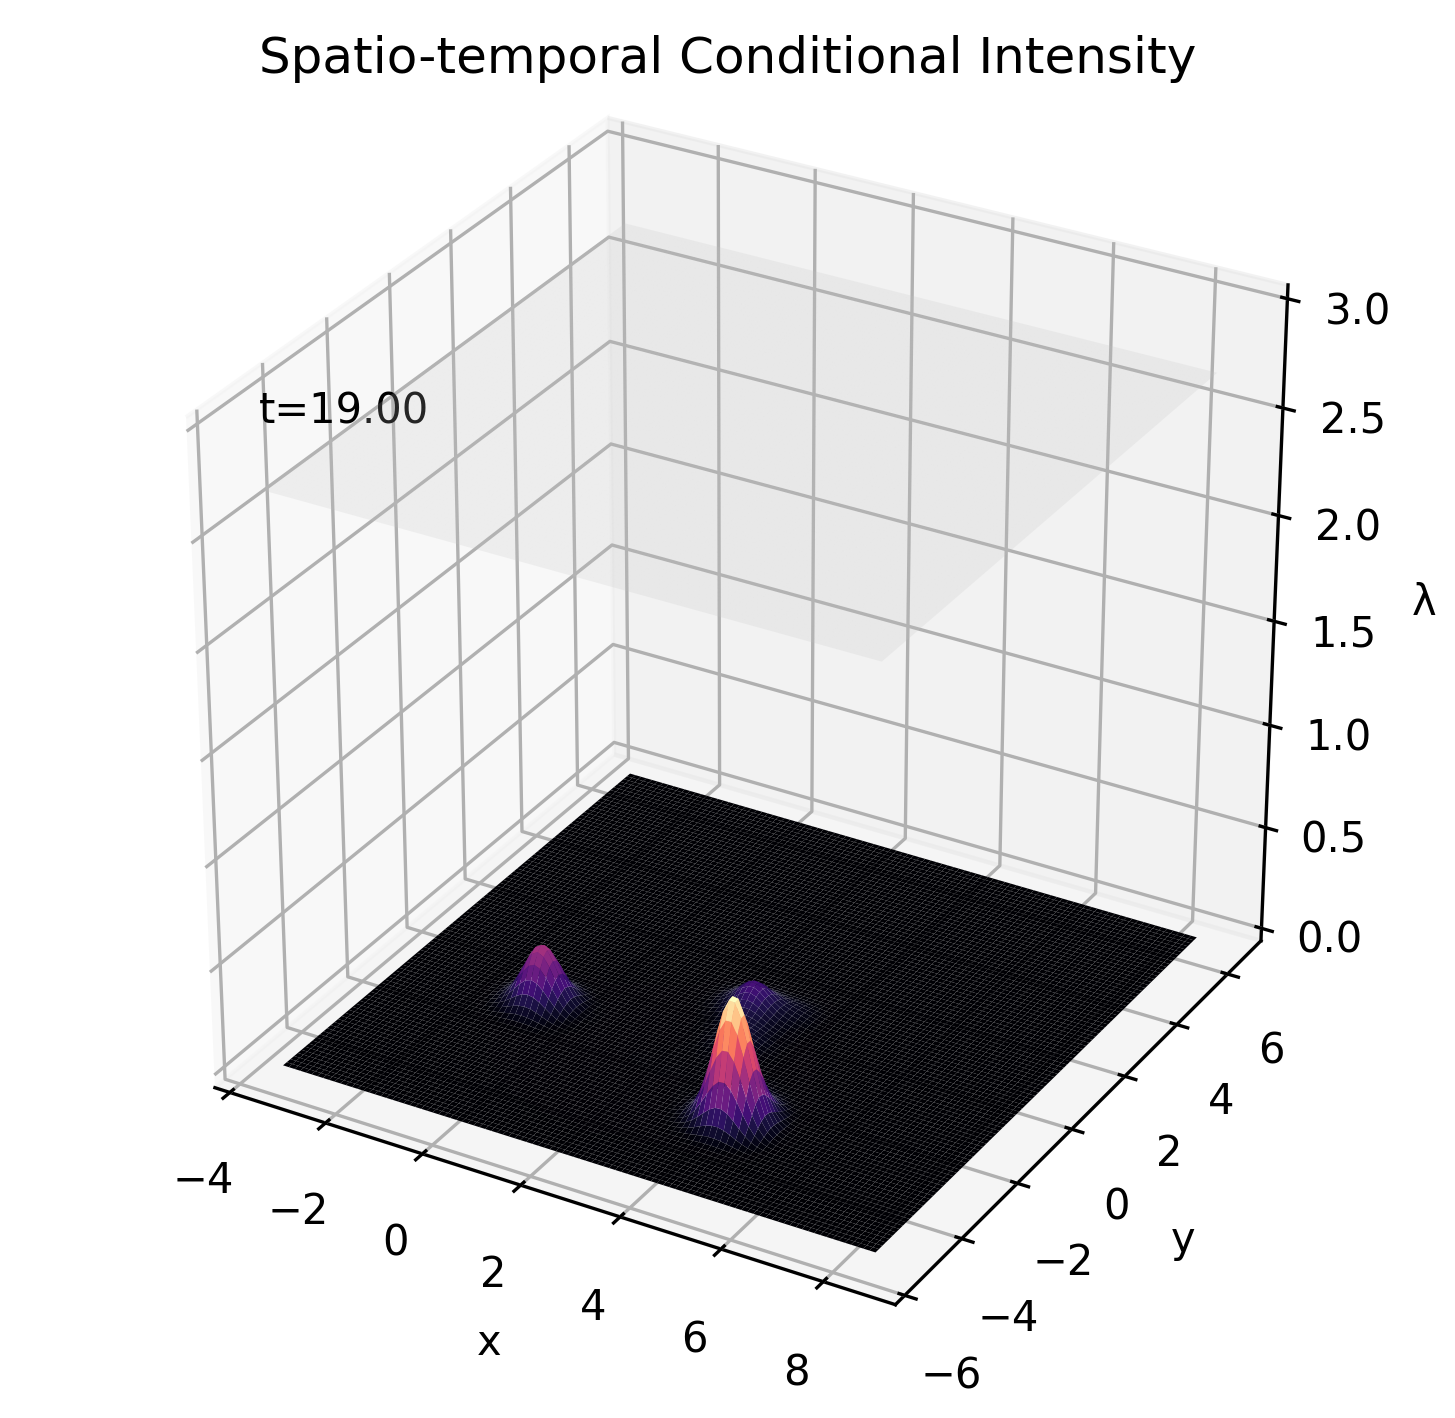

In [ ]:
print(np.max(lambs))
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=0.3,
                   scaler=None, cmax=3.0, fps=12, fn=f'../video/{dataset}_ab.mp4')

### Shared Decoder

In [35]:
config.sample=True

In [ ]:
from ablation.model_shared import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/shared/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:22:55,346 INFO In epochs 0 | total loss: 4.829599 | Space: -1.515442 | Time: 2.827628


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:22:56,297 INFO In epochs 1 | total loss: 2.417799 | Space: -1.457404 | Time: 2.852136


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:22:57,291 INFO In epochs 2 | total loss: 1.611924 | Space: -1.393288 | Time: 2.871476


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:22:58,238 INFO In epochs 3 | total loss: 1.208865 | Space: -1.327090 | Time: 2.886814


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:22:59,167 INFO In epochs 4 | total loss: 0.966878 | Space: -1.258511 | Time: 2.902376
2021-12-06 04:22:59,211 INFO Val Loss -0.000624 | Space: -0.906503 | Time: 2.410551


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:00,135 INFO In epochs 5 | total loss: 0.805596 | Space: -1.184565 | Time: 2.912676


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:01,059 INFO In epochs 6 | total loss: 0.690270 | Space: -1.104372 | Time: 2.924192


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:01,982 INFO In epochs 7 | total loss: 0.603870 | Space: -1.015112 | Time: 2.933587


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:02,955 INFO In epochs 8 | total loss: 0.536891 | Space: -0.923681 | Time: 2.940740


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:04,122 INFO In epochs 9 | total loss: 0.482939 | Space: -0.824523 | Time: 2.947200
2021-12-06 04:23:04,168 INFO Val Loss -0.002130 | Space: 0.220647 | Time: 2.244823


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:05,117 INFO In epochs 10 | total loss: 0.438774 | Space: -0.715227 | Time: 2.951159


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:06,045 INFO In epochs 11 | total loss: 0.401931 | Space: -0.598158 | Time: 2.956072


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:06,946 INFO In epochs 12 | total loss: 0.370718 | Space: -0.473041 | Time: 2.959219


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:07,861 INFO In epochs 13 | total loss: 0.344023 | Space: -0.336582 | Time: 2.962286


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:08,792 INFO In epochs 14 | total loss: 0.320824 | Space: -0.190176 | Time: 2.966022
2021-12-06 04:23:08,849 INFO Val Loss -0.004050 | Space: 2.092304 | Time: 2.170896


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:09,801 INFO In epochs 15 | total loss: 0.300459 | Space: -0.040190 | Time: 2.969533


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:10,736 INFO In epochs 16 | total loss: 0.282486 | Space: 0.110423 | Time: 2.971271


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:11,671 INFO In epochs 17 | total loss: 0.266485 | Space: 0.253147 | Time: 2.971642


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:12,610 INFO In epochs 18 | total loss: 0.252178 | Space: 0.386841 | Time: 2.973655


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:13,519 INFO In epochs 19 | total loss: 0.239305 | Space: 0.510072 | Time: 2.976023
2021-12-06 04:23:13,564 INFO Val Loss -0.004984 | Space: 2.771996 | Time: 2.356503


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:14,488 INFO In epochs 20 | total loss: 0.227644 | Space: 0.623700 | Time: 2.978070


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:15,425 INFO In epochs 21 | total loss: 0.217041 | Space: 0.727857 | Time: 2.980201


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:16,380 INFO In epochs 22 | total loss: 0.207393 | Space: 0.823573 | Time: 2.982023


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:17,298 INFO In epochs 23 | total loss: 0.198531 | Space: 0.911779 | Time: 2.983787


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:18,233 INFO In epochs 24 | total loss: 0.190363 | Space: 0.993763 | Time: 2.985569
2021-12-06 04:23:18,277 INFO Val Loss -0.004943 | Space: 2.827761 | Time: 2.351246


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:19,193 INFO In epochs 25 | total loss: 0.182815 | Space: 1.069830 | Time: 2.986571


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:20,121 INFO In epochs 26 | total loss: 0.175843 | Space: 1.140951 | Time: 2.988127


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:21,067 INFO In epochs 27 | total loss: 0.169360 | Space: 1.207130 | Time: 2.989702


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:21,988 INFO In epochs 28 | total loss: 0.163328 | Space: 1.268890 | Time: 2.991395


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:22,906 INFO In epochs 29 | total loss: 0.157686 | Space: 1.326785 | Time: 2.992532
2021-12-06 04:23:22,956 INFO Val Loss -0.004991 | Space: 2.807910 | Time: 2.366055


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:23,878 INFO In epochs 30 | total loss: 0.152426 | Space: 1.381373 | Time: 2.993904


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:24,796 INFO In epochs 31 | total loss: 0.147492 | Space: 1.432443 | Time: 2.995138


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:25,713 INFO In epochs 32 | total loss: 0.142843 | Space: 1.480418 | Time: 2.996546


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:26,616 INFO In epochs 33 | total loss: 0.138471 | Space: 1.526121 | Time: 2.997744


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:27,545 INFO In epochs 34 | total loss: 0.134359 | Space: 1.568972 | Time: 2.998774
2021-12-06 04:23:27,594 INFO Val Loss -0.005146 | Space: 2.899064 | Time: 2.320892


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:28,558 INFO In epochs 35 | total loss: 0.130459 | Space: 1.610118 | Time: 3.000212


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:29,501 INFO In epochs 36 | total loss: 0.126779 | Space: 1.648888 | Time: 3.001655


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:30,445 INFO In epochs 37 | total loss: 0.123290 | Space: 1.685985 | Time: 3.002791


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:31,381 INFO In epochs 38 | total loss: 0.119978 | Space: 1.720895 | Time: 3.003817


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:32,305 INFO In epochs 39 | total loss: 0.116852 | Space: 1.754527 | Time: 3.004926
2021-12-06 04:23:32,353 INFO Val Loss -0.004538 | Space: 2.907444 | Time: 2.340008


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:33,491 INFO In epochs 40 | total loss: 0.113858 | Space: 1.786656 | Time: 3.005578


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:34,414 INFO In epochs 41 | total loss: 0.111016 | Space: 1.816983 | Time: 3.006919


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:35,335 INFO In epochs 42 | total loss: 0.108295 | Space: 1.845549 | Time: 3.008245


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:36,246 INFO In epochs 43 | total loss: 0.105729 | Space: 1.872746 | Time: 3.009687


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:37,166 INFO In epochs 44 | total loss: 0.103250 | Space: 1.898863 | Time: 3.011052
2021-12-06 04:23:37,211 INFO Val Loss -0.005224 | Space: 2.917620 | Time: 2.342164


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:38,141 INFO In epochs 45 | total loss: 0.100879 | Space: 1.923648 | Time: 3.012302


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:39,081 INFO In epochs 46 | total loss: 0.098621 | Space: 1.947445 | Time: 3.013618


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:40,000 INFO In epochs 47 | total loss: 0.096441 | Space: 1.970120 | Time: 3.014970


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:40,926 INFO In epochs 48 | total loss: 0.094349 | Space: 1.991949 | Time: 3.016219


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:41,844 INFO In epochs 49 | total loss: 0.092347 | Space: 2.013143 | Time: 3.017252
2021-12-06 04:23:41,892 INFO Val Loss -0.004988 | Space: 2.877369 | Time: 2.330120


Evaluate
training done!


In [ ]:
from ablation.model_shared import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/shared/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:43,743 INFO In epochs 0 | total loss: 4.860430 | Space: -1.511106 | Time: 2.835671


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:44,636 INFO In epochs 1 | total loss: 2.433477 | Space: -1.450560 | Time: 2.858543


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:45,530 INFO In epochs 2 | total loss: 1.622379 | Space: -1.378979 | Time: 2.879355


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:46,439 INFO In epochs 3 | total loss: 1.216593 | Space: -1.297055 | Time: 2.899648


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:47,340 INFO In epochs 4 | total loss: 0.973752 | Space: -1.207578 | Time: 2.915830
2021-12-06 04:23:47,386 INFO Val Loss 0.000463 | Space: -0.797175 | Time: 2.413912


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:48,273 INFO In epochs 5 | total loss: 0.811196 | Space: -1.112285 | Time: 2.929404


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:49,162 INFO In epochs 6 | total loss: 0.695011 | Space: -1.007670 | Time: 2.937702


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:50,084 INFO In epochs 7 | total loss: 0.607844 | Space: -0.891518 | Time: 2.945962


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:50,970 INFO In epochs 8 | total loss: 0.539992 | Space: -0.757389 | Time: 2.953318


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:51,846 INFO In epochs 9 | total loss: 0.485668 | Space: -0.609918 | Time: 2.959085
2021-12-06 04:23:51,894 INFO Val Loss -0.002646 | Space: 0.896301 | Time: 2.250334


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:52,820 INFO In epochs 10 | total loss: 0.441215 | Space: -0.447429 | Time: 2.960949


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:53,759 INFO In epochs 11 | total loss: 0.404096 | Space: -0.267994 | Time: 2.964035


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:54,667 INFO In epochs 12 | total loss: 0.372652 | Space: -0.080047 | Time: 2.968848


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:55,574 INFO In epochs 13 | total loss: 0.345669 | Space: 0.106626 | Time: 2.972880


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:56,495 INFO In epochs 14 | total loss: 0.322267 | Space: 0.282582 | Time: 2.977383
2021-12-06 04:23:56,543 INFO Val Loss -0.004655 | Space: 2.791315 | Time: 2.326267


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:57,450 INFO In epochs 15 | total loss: 0.301788 | Space: 0.442738 | Time: 2.980227


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:58,374 INFO In epochs 16 | total loss: 0.283726 | Space: 0.587347 | Time: 2.982830


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:23:59,303 INFO In epochs 17 | total loss: 0.267667 | Space: 0.718670 | Time: 2.986094


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:00,218 INFO In epochs 18 | total loss: 0.253286 | Space: 0.837188 | Time: 2.989620


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:01,116 INFO In epochs 19 | total loss: 0.240353 | Space: 0.944260 | Time: 2.993572
2021-12-06 04:24:01,168 INFO Val Loss -0.004980 | Space: 2.871132 | Time: 2.324839


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:02,312 INFO In epochs 20 | total loss: 0.228625 | Space: 1.041169 | Time: 2.996923


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:03,230 INFO In epochs 21 | total loss: 0.217993 | Space: 1.130693 | Time: 3.000312


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:04,172 INFO In epochs 22 | total loss: 0.208263 | Space: 1.212378 | Time: 3.003729


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:05,081 INFO In epochs 23 | total loss: 0.199348 | Space: 1.287639 | Time: 3.006828


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:05,994 INFO In epochs 24 | total loss: 0.191144 | Space: 1.357740 | Time: 3.010069
2021-12-06 04:24:06,037 INFO Val Loss -0.004381 | Space: 2.831820 | Time: 2.410580


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:06,964 INFO In epochs 25 | total loss: 0.183565 | Space: 1.422844 | Time: 3.013181


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:07,875 INFO In epochs 26 | total loss: 0.176560 | Space: 1.483411 | Time: 3.015820


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:08,799 INFO In epochs 27 | total loss: 0.170060 | Space: 1.539788 | Time: 3.018279


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:09,758 INFO In epochs 28 | total loss: 0.163987 | Space: 1.592611 | Time: 3.020996


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:10,668 INFO In epochs 29 | total loss: 0.158335 | Space: 1.641872 | Time: 3.023610
2021-12-06 04:24:10,716 INFO Val Loss -0.004366 | Space: 2.947125 | Time: 2.403034


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:11,659 INFO In epochs 30 | total loss: 0.153044 | Space: 1.688437 | Time: 3.026272


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:12,607 INFO In epochs 31 | total loss: 0.148072 | Space: 1.732272 | Time: 3.028767


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:13,571 INFO In epochs 32 | total loss: 0.143410 | Space: 1.773234 | Time: 3.031578


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:14,490 INFO In epochs 33 | total loss: 0.139034 | Space: 1.811897 | Time: 3.033690


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:15,426 INFO In epochs 34 | total loss: 0.134888 | Space: 1.848518 | Time: 3.036102
2021-12-06 04:24:15,471 INFO Val Loss -0.004665 | Space: 2.929626 | Time: 2.408787


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:16,408 INFO In epochs 35 | total loss: 0.130974 | Space: 1.883351 | Time: 3.038834


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:17,332 INFO In epochs 36 | total loss: 0.127278 | Space: 1.916357 | Time: 3.041207


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:18,279 INFO In epochs 37 | total loss: 0.123774 | Space: 1.947702 | Time: 3.043584


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:19,230 INFO In epochs 38 | total loss: 0.120452 | Space: 1.977398 | Time: 3.045870


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:20,148 INFO In epochs 39 | total loss: 0.117290 | Space: 2.005272 | Time: 3.048316
2021-12-06 04:24:20,199 INFO Val Loss -0.005277 | Space: 2.993391 | Time: 2.426576


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:21,128 INFO In epochs 40 | total loss: 0.114305 | Space: 2.031206 | Time: 3.050657


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:22,054 INFO In epochs 41 | total loss: 0.111437 | Space: 2.055872 | Time: 3.053056


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:22,968 INFO In epochs 42 | total loss: 0.108707 | Space: 2.079543 | Time: 3.055304


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:23,910 INFO In epochs 43 | total loss: 0.106114 | Space: 2.101929 | Time: 3.057606


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:24,843 INFO In epochs 44 | total loss: 0.103631 | Space: 2.123718 | Time: 3.059859
2021-12-06 04:24:24,888 INFO Val Loss -0.005206 | Space: 2.956698 | Time: 2.436561


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:25,829 INFO In epochs 45 | total loss: 0.101245 | Space: 2.144320 | Time: 3.061763


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:26,742 INFO In epochs 46 | total loss: 0.098962 | Space: 2.164280 | Time: 3.063852


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:27,651 INFO In epochs 47 | total loss: 0.096781 | Space: 2.183270 | Time: 3.066000


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:28,589 INFO In epochs 48 | total loss: 0.094682 | Space: 2.201688 | Time: 3.068175


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:29,526 INFO In epochs 49 | total loss: 0.092669 | Space: 2.219806 | Time: 3.070378
2021-12-06 04:24:29,575 INFO Val Loss -0.005402 | Space: 3.003834 | Time: 2.442350


Evaluate
training done!


In [ ]:
from ablation.model_shared import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/shared/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:30,921 INFO In epochs 0 | total loss: 3.960791 | Space: -1.519565 | Time: 2.836879


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:31,832 INFO In epochs 1 | total loss: 1.982896 | Space: -1.452531 | Time: 2.860183


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:32,955 INFO In epochs 2 | total loss: 1.321929 | Space: -1.374409 | Time: 2.883180


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:33,873 INFO In epochs 3 | total loss: 0.991289 | Space: -1.292020 | Time: 2.902165


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:34,786 INFO In epochs 4 | total loss: 0.792884 | Space: -1.206311 | Time: 2.919242
2021-12-06 04:24:34,827 INFO Val Loss -0.000791 | Space: -0.786822 | Time: 2.393991


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:35,714 INFO In epochs 5 | total loss: 0.660489 | Space: -1.117907 | Time: 2.930250


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:36,632 INFO In epochs 6 | total loss: 0.565967 | Space: -1.022344 | Time: 2.940669


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:37,536 INFO In epochs 7 | total loss: 0.494971 | Space: -0.917758 | Time: 2.946936


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:38,481 INFO In epochs 8 | total loss: 0.439657 | Space: -0.801489 | Time: 2.953907


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:39,409 INFO In epochs 9 | total loss: 0.395399 | Space: -0.672865 | Time: 2.958706
2021-12-06 04:24:39,456 INFO Val Loss -0.002041 | Space: 0.546762 | Time: 2.271603


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:40,399 INFO In epochs 10 | total loss: 0.359135 | Space: -0.534211 | Time: 2.963413


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:41,315 INFO In epochs 11 | total loss: 0.328890 | Space: -0.385315 | Time: 2.967722


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:42,216 INFO In epochs 12 | total loss: 0.303279 | Space: -0.222600 | Time: 2.970710


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:43,123 INFO In epochs 13 | total loss: 0.281288 | Space: -0.055331 | Time: 2.971936


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:44,057 INFO In epochs 14 | total loss: 0.262198 | Space: 0.112581 | Time: 2.975586
2021-12-06 04:24:44,104 INFO Val Loss -0.004583 | Space: 2.452769 | Time: 2.315627


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:45,033 INFO In epochs 15 | total loss: 0.245476 | Space: 0.273652 | Time: 2.978997


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:45,972 INFO In epochs 16 | total loss: 0.230724 | Space: 0.422487 | Time: 2.981553


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:46,873 INFO In epochs 17 | total loss: 0.217597 | Space: 0.557466 | Time: 2.983516


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:47,808 INFO In epochs 18 | total loss: 0.205865 | Space: 0.680846 | Time: 2.986129


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:48,724 INFO In epochs 19 | total loss: 0.195305 | Space: 0.792989 | Time: 2.989350
2021-12-06 04:24:48,771 INFO Val Loss -0.004954 | Space: 2.711166 | Time: 2.383722


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:49,661 INFO In epochs 20 | total loss: 0.185724 | Space: 0.896196 | Time: 2.992542


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:50,552 INFO In epochs 21 | total loss: 0.177031 | Space: 0.991141 | Time: 2.995279


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:51,476 INFO In epochs 22 | total loss: 0.169113 | Space: 1.077922 | Time: 2.997924


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:52,393 INFO In epochs 23 | total loss: 0.161818 | Space: 1.157944 | Time: 3.000422


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:53,310 INFO In epochs 24 | total loss: 0.155116 | Space: 1.232057 | Time: 3.002526
2021-12-06 04:24:53,359 INFO Val Loss -0.005142 | Space: 2.935179 | Time: 2.336906


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:54,314 INFO In epochs 25 | total loss: 0.148926 | Space: 1.300839 | Time: 3.005313


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:55,221 INFO In epochs 26 | total loss: 0.143196 | Space: 1.365333 | Time: 3.007796


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:56,133 INFO In epochs 27 | total loss: 0.137873 | Space: 1.425335 | Time: 3.010368


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:57,116 INFO In epochs 28 | total loss: 0.132926 | Space: 1.481444 | Time: 3.012850


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:58,087 INFO In epochs 29 | total loss: 0.128296 | Space: 1.534289 | Time: 3.014757
2021-12-06 04:24:58,136 INFO Val Loss -0.004274 | Space: 2.889210 | Time: 2.380990


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:24:59,072 INFO In epochs 30 | total loss: 0.123971 | Space: 1.583825 | Time: 3.017237


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:00,011 INFO In epochs 31 | total loss: 0.119914 | Space: 1.630331 | Time: 3.019840


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:00,980 INFO In epochs 32 | total loss: 0.116099 | Space: 1.674080 | Time: 3.022199


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:01,918 INFO In epochs 33 | total loss: 0.112515 | Space: 1.715741 | Time: 3.023728


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:03,092 INFO In epochs 34 | total loss: 0.109136 | Space: 1.755009 | Time: 3.025996
2021-12-06 04:25:03,142 INFO Val Loss -0.004222 | Space: 2.920573 | Time: 2.408201


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:04,075 INFO In epochs 35 | total loss: 0.105961 | Space: 1.792266 | Time: 3.028582


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:04,991 INFO In epochs 36 | total loss: 0.102934 | Space: 1.827415 | Time: 3.030846


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:05,890 INFO In epochs 37 | total loss: 0.100064 | Space: 1.860567 | Time: 3.033109


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:06,803 INFO In epochs 38 | total loss: 0.097347 | Space: 1.892601 | Time: 3.035612


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:07,736 INFO In epochs 39 | total loss: 0.094762 | Space: 1.922684 | Time: 3.037748
2021-12-06 04:25:07,783 INFO Val Loss -0.005199 | Space: 2.940598 | Time: 2.405284


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:08,717 INFO In epochs 40 | total loss: 0.092307 | Space: 1.951508 | Time: 3.039917


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:09,644 INFO In epochs 41 | total loss: 0.089973 | Space: 1.978421 | Time: 3.041891


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:10,558 INFO In epochs 42 | total loss: 0.087740 | Space: 2.004431 | Time: 3.043916


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:11,493 INFO In epochs 43 | total loss: 0.085621 | Space: 2.029424 | Time: 3.046164


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:12,418 INFO In epochs 44 | total loss: 0.083581 | Space: 2.052941 | Time: 3.048528
2021-12-06 04:25:12,467 INFO Val Loss -0.005336 | Space: 2.928864 | Time: 2.461208


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:13,424 INFO In epochs 45 | total loss: 0.081630 | Space: 2.075388 | Time: 3.050855


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:14,366 INFO In epochs 46 | total loss: 0.079770 | Space: 2.096974 | Time: 3.052888


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:15,303 INFO In epochs 47 | total loss: 0.077984 | Space: 2.117645 | Time: 3.054834


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:16,226 INFO In epochs 48 | total loss: 0.076269 | Space: 2.137689 | Time: 3.057106


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:25:17,199 INFO In epochs 49 | total loss: 0.074626 | Space: 2.156811 | Time: 3.059297
2021-12-06 04:25:17,243 INFO Val Loss -0.005251 | Space: 2.944552 | Time: 2.442555


Evaluate
training done!


In [38]:
from ablation.model_shared import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/shared/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-2.4397 ± 0.0170
-0.6060 ± 0.0381


### Separate Encoders

In [ ]:
from ablation.model_sepenc import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/sepenc/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:42,417 INFO In epochs 0 | total loss: 12.345723 | Space: -1.516758 | Time: 2.830715


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:44,556 INFO In epochs 1 | total loss: 6.183071 | Space: -0.883401 | Time: 2.896297


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:46,643 INFO In epochs 2 | total loss: 4.122746 | Space: 0.289187 | Time: 2.932756


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:48,761 INFO In epochs 3 | total loss: 3.093321 | Space: 0.963083 | Time: 2.952151


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:50,862 INFO In epochs 4 | total loss: 2.474652 | Space: 1.376786 | Time: 2.963473
2021-12-06 04:31:50,942 INFO Val Loss -0.000329 | Space: 2.915246 | Time: 2.337819


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:53,046 INFO In epochs 5 | total loss: 2.061835 | Space: 1.656353 | Time: 2.970711


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:55,122 INFO In epochs 6 | total loss: 1.766994 | Space: 1.856280 | Time: 2.976847


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:57,204 INFO In epochs 7 | total loss: 1.546050 | Space: 2.007415 | Time: 2.981220


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:31:59,300 INFO In epochs 8 | total loss: 1.374317 | Space: 2.125180 | Time: 2.984897


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:01,408 INFO In epochs 9 | total loss: 1.236760 | Space: 2.218907 | Time: 2.985266
2021-12-06 04:32:01,491 INFO Val Loss -0.002340 | Space: 2.931646 | Time: 2.269533


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:03,799 INFO In epochs 10 | total loss: 1.123988 | Space: 2.295523 | Time: 2.986280


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:05,933 INFO In epochs 11 | total loss: 1.029899 | Space: 2.360534 | Time: 2.987974


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:08,005 INFO In epochs 12 | total loss: 0.950304 | Space: 2.415469 | Time: 2.989698


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:10,085 INFO In epochs 13 | total loss: 0.882072 | Space: 2.462712 | Time: 2.991181


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:12,213 INFO In epochs 14 | total loss: 0.822949 | Space: 2.503062 | Time: 2.992195
2021-12-06 04:32:12,295 INFO Val Loss -0.002727 | Space: 2.926565 | Time: 2.202613


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:14,410 INFO In epochs 15 | total loss: 0.771528 | Space: 2.539626 | Time: 2.993577


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:16,573 INFO In epochs 16 | total loss: 0.726033 | Space: 2.571294 | Time: 2.994565


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:18,730 INFO In epochs 17 | total loss: 0.685475 | Space: 2.599968 | Time: 2.995770


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:20,904 INFO In epochs 18 | total loss: 0.649142 | Space: 2.625243 | Time: 2.996334


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:23,037 INFO In epochs 19 | total loss: 0.616424 | Space: 2.648439 | Time: 2.997325
2021-12-06 04:32:23,135 INFO Val Loss -0.003744 | Space: 2.879844 | Time: 2.234438


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:25,346 INFO In epochs 20 | total loss: 0.586820 | Space: 2.669169 | Time: 2.998111


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:27,440 INFO In epochs 21 | total loss: 0.559914 | Space: 2.687729 | Time: 2.998325


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:29,598 INFO In epochs 22 | total loss: 0.535339 | Space: 2.705060 | Time: 2.999093


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:31,756 INFO In epochs 23 | total loss: 0.512860 | Space: 2.721357 | Time: 2.999598


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:33,869 INFO In epochs 24 | total loss: 0.492142 | Space: 2.736075 | Time: 3.000502
2021-12-06 04:32:33,953 INFO Val Loss -0.003478 | Space: 2.904474 | Time: 2.226220


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:36,130 INFO In epochs 25 | total loss: 0.473011 | Space: 2.749521 | Time: 3.000829


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:38,206 INFO In epochs 26 | total loss: 0.455294 | Space: 2.762323 | Time: 3.001362


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:40,311 INFO In epochs 27 | total loss: 0.438987 | Space: 2.774279 | Time: 3.002068


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:42,453 INFO In epochs 28 | total loss: 0.423721 | Space: 2.785108 | Time: 3.002649


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:44,554 INFO In epochs 29 | total loss: 0.409431 | Space: 2.795525 | Time: 3.003147
2021-12-06 04:32:44,646 INFO Val Loss -0.004878 | Space: 2.896380 | Time: 2.261201


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:46,785 INFO In epochs 30 | total loss: 0.396073 | Space: 2.805166 | Time: 3.003419


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:48,956 INFO In epochs 31 | total loss: 0.383551 | Space: 2.814258 | Time: 3.004220


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:51,139 INFO In epochs 32 | total loss: 0.371773 | Space: 2.822722 | Time: 3.004674


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:53,323 INFO In epochs 33 | total loss: 0.360671 | Space: 2.830621 | Time: 3.005053


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:55,509 INFO In epochs 34 | total loss: 0.350211 | Space: 2.838116 | Time: 3.005214
2021-12-06 04:32:55,598 INFO Val Loss -0.004642 | Space: 2.925124 | Time: 2.264996


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:57,724 INFO In epochs 35 | total loss: 0.340338 | Space: 2.845225 | Time: 3.005615


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:32:59,883 INFO In epochs 36 | total loss: 0.331000 | Space: 2.851996 | Time: 3.005624


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:02,013 INFO In epochs 37 | total loss: 0.322150 | Space: 2.858157 | Time: 3.005743


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:04,135 INFO In epochs 38 | total loss: 0.313757 | Space: 2.864239 | Time: 3.005420


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:06,284 INFO In epochs 39 | total loss: 0.305801 | Space: 2.869964 | Time: 3.005887
2021-12-06 04:33:06,375 INFO Val Loss -0.003962 | Space: 2.900862 | Time: 2.233411


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:08,573 INFO In epochs 40 | total loss: 0.298223 | Space: 2.875510 | Time: 3.006219


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:10,907 INFO In epochs 41 | total loss: 0.291003 | Space: 2.880708 | Time: 3.006635


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:13,095 INFO In epochs 42 | total loss: 0.284110 | Space: 2.885802 | Time: 3.006211


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:15,275 INFO In epochs 43 | total loss: 0.277540 | Space: 2.890568 | Time: 3.006507


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:17,527 INFO In epochs 44 | total loss: 0.271257 | Space: 2.895172 | Time: 3.007068
2021-12-06 04:33:17,634 INFO Val Loss -0.004168 | Space: 2.917266 | Time: 2.271814


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:19,747 INFO In epochs 45 | total loss: 0.265245 | Space: 2.899552 | Time: 3.007497


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:21,903 INFO In epochs 46 | total loss: 0.259503 | Space: 2.903773 | Time: 3.007719


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:24,144 INFO In epochs 47 | total loss: 0.253982 | Space: 2.907618 | Time: 3.008065


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:26,301 INFO In epochs 48 | total loss: 0.248697 | Space: 2.911571 | Time: 3.008493


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:28,455 INFO In epochs 49 | total loss: 0.243612 | Space: 2.915408 | Time: 3.008599
2021-12-06 04:33:28,554 INFO Val Loss -0.004656 | Space: 2.905739 | Time: 2.288531


Evaluate
training done!


In [ ]:
from ablation.model_sepenc import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/sepenc/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:32,004 INFO In epochs 0 | total loss: 12.853686 | Space: -1.508368 | Time: 2.840618


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:34,140 INFO In epochs 1 | total loss: 6.436188 | Space: -0.847174 | Time: 2.900333


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:36,207 INFO In epochs 2 | total loss: 4.291209 | Space: 0.296303 | Time: 2.924634


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:38,371 INFO In epochs 3 | total loss: 3.218213 | Space: 0.956779 | Time: 2.943273


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:40,493 INFO In epochs 4 | total loss: 2.573980 | Space: 1.366833 | Time: 2.955319
2021-12-06 04:33:40,584 INFO Val Loss -0.001104 | Space: 2.905659 | Time: 2.193793


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:42,711 INFO In epochs 5 | total loss: 2.144336 | Space: 1.646230 | Time: 2.964257


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:44,837 INFO In epochs 6 | total loss: 1.837412 | Space: 1.847382 | Time: 2.969761


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:46,958 INFO In epochs 7 | total loss: 1.607193 | Space: 1.999411 | Time: 2.972654


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:49,034 INFO In epochs 8 | total loss: 1.428129 | Space: 2.118907 | Time: 2.977735


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:51,139 INFO In epochs 9 | total loss: 1.284871 | Space: 2.213854 | Time: 2.980766
2021-12-06 04:33:51,226 INFO Val Loss -0.003797 | Space: 2.873213 | Time: 2.163243


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:53,353 INFO In epochs 10 | total loss: 1.167953 | Space: 2.292827 | Time: 2.983834


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:55,462 INFO In epochs 11 | total loss: 1.070410 | Space: 2.358438 | Time: 2.986384


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:57,630 INFO In epochs 12 | total loss: 0.987743 | Space: 2.412666 | Time: 2.988878


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:33:59,722 INFO In epochs 13 | total loss: 0.916961 | Space: 2.460542 | Time: 2.989937


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:01,812 INFO In epochs 14 | total loss: 0.855518 | Space: 2.501353 | Time: 2.991246
2021-12-06 04:34:01,912 INFO Val Loss -0.004512 | Space: 2.885485 | Time: 2.265477


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:04,022 INFO In epochs 15 | total loss: 0.801745 | Space: 2.536794 | Time: 2.992329


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:06,135 INFO In epochs 16 | total loss: 0.754315 | Space: 2.568836 | Time: 2.991817


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:08,206 INFO In epochs 17 | total loss: 0.712227 | Space: 2.597401 | Time: 2.992829


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:10,272 INFO In epochs 18 | total loss: 0.674482 | Space: 2.622949 | Time: 2.992593


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:12,348 INFO In epochs 19 | total loss: 0.640490 | Space: 2.645665 | Time: 2.993413
2021-12-06 04:34:12,438 INFO Val Loss -0.004644 | Space: 2.892836 | Time: 2.272413


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:14,545 INFO In epochs 20 | total loss: 0.609747 | Space: 2.666369 | Time: 2.994128


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:16,865 INFO In epochs 21 | total loss: 0.581787 | Space: 2.685434 | Time: 2.994390


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:19,062 INFO In epochs 22 | total loss: 0.556280 | Space: 2.702863 | Time: 2.994834


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:21,143 INFO In epochs 23 | total loss: 0.532908 | Space: 2.718857 | Time: 2.995019


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:23,301 INFO In epochs 24 | total loss: 0.511398 | Space: 2.733798 | Time: 2.995433
2021-12-06 04:34:23,388 INFO Val Loss -0.002959 | Space: 2.892251 | Time: 2.266907


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:25,564 INFO In epochs 25 | total loss: 0.491549 | Space: 2.747277 | Time: 2.996039


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:27,743 INFO In epochs 26 | total loss: 0.473175 | Space: 2.759888 | Time: 2.996544


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:29,872 INFO In epochs 27 | total loss: 0.456089 | Space: 2.771363 | Time: 2.996611


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:32,006 INFO In epochs 28 | total loss: 0.440187 | Space: 2.782294 | Time: 2.997068


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:34,103 INFO In epochs 29 | total loss: 0.425334 | Space: 2.792504 | Time: 2.997239
2021-12-06 04:34:34,186 INFO Val Loss -0.003938 | Space: 2.925259 | Time: 2.250278


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:36,303 INFO In epochs 30 | total loss: 0.411454 | Space: 2.802055 | Time: 2.997788


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:38,470 INFO In epochs 31 | total loss: 0.398457 | Space: 2.811281 | Time: 2.998095


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:40,579 INFO In epochs 32 | total loss: 0.386235 | Space: 2.819851 | Time: 2.998711


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:42,700 INFO In epochs 33 | total loss: 0.374731 | Space: 2.827938 | Time: 2.999253


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:44,895 INFO In epochs 34 | total loss: 0.363900 | Space: 2.835402 | Time: 2.999633
2021-12-06 04:34:44,981 INFO Val Loss -0.004320 | Space: 2.925699 | Time: 2.305277


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:47,132 INFO In epochs 35 | total loss: 0.353645 | Space: 2.842418 | Time: 2.999531


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:49,394 INFO In epochs 36 | total loss: 0.343942 | Space: 2.849388 | Time: 2.999915


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:51,565 INFO In epochs 37 | total loss: 0.334747 | Space: 2.855839 | Time: 3.000039


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:53,750 INFO In epochs 38 | total loss: 0.326032 | Space: 2.861972 | Time: 3.000143


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:55,950 INFO In epochs 39 | total loss: 0.317775 | Space: 2.867761 | Time: 3.000423
2021-12-06 04:34:56,038 INFO Val Loss -0.000195 | Space: 2.902718 | Time: 2.228467


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:34:58,187 INFO In epochs 40 | total loss: 0.309961 | Space: 2.873165 | Time: 3.000883


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:00,347 INFO In epochs 41 | total loss: 0.302494 | Space: 2.878565 | Time: 3.001035


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:02,514 INFO In epochs 42 | total loss: 0.295343 | Space: 2.883680 | Time: 3.001356


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:04,717 INFO In epochs 43 | total loss: 0.288589 | Space: 2.888397 | Time: 3.001547


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:06,920 INFO In epochs 44 | total loss: 0.282062 | Space: 2.893005 | Time: 3.001879
2021-12-06 04:35:07,022 INFO Val Loss -0.004912 | Space: 2.912545 | Time: 2.216033


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:09,203 INFO In epochs 45 | total loss: 0.275811 | Space: 2.897505 | Time: 3.001572


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:11,326 INFO In epochs 46 | total loss: 0.269851 | Space: 2.901844 | Time: 3.001609


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:13,478 INFO In epochs 47 | total loss: 0.264123 | Space: 2.905713 | Time: 3.001684


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:15,634 INFO In epochs 48 | total loss: 0.258618 | Space: 2.909523 | Time: 3.001863


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:17,889 INFO In epochs 49 | total loss: 0.253335 | Space: 2.913301 | Time: 3.002018
2021-12-06 04:35:17,986 INFO Val Loss -0.004557 | Space: 2.934537 | Time: 2.258324


Evaluate
training done!


In [ ]:
from ablation.model_sepenc import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/sepenc/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:21,046 INFO In epochs 0 | total loss: 11.908275 | Space: -1.497706 | Time: 2.842299


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:23,168 INFO In epochs 1 | total loss: 5.964687 | Space: -0.904411 | Time: 2.902390


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:25,275 INFO In epochs 2 | total loss: 3.978326 | Space: 0.240063 | Time: 2.937711


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:27,345 INFO In epochs 3 | total loss: 2.984392 | Space: 0.909106 | Time: 2.955141


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:29,717 INFO In epochs 4 | total loss: 2.387821 | Space: 1.331251 | Time: 2.966642
2021-12-06 04:35:29,802 INFO Val Loss 0.000740 | Space: 2.866560 | Time: 2.260089


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:31,920 INFO In epochs 5 | total loss: 1.989534 | Space: 1.617378 | Time: 2.975659


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:34,010 INFO In epochs 6 | total loss: 1.704857 | Space: 1.822737 | Time: 2.979896


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:36,211 INFO In epochs 7 | total loss: 1.491248 | Space: 1.977263 | Time: 2.984814


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:38,350 INFO In epochs 8 | total loss: 1.325370 | Space: 2.098236 | Time: 2.987813


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:40,511 INFO In epochs 9 | total loss: 1.192768 | Space: 2.194928 | Time: 2.988415
2021-12-06 04:35:40,595 INFO Val Loss 0.000053 | Space: 2.896415 | Time: 2.287160


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:42,759 INFO In epochs 10 | total loss: 1.084235 | Space: 2.275071 | Time: 2.990393


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:44,949 INFO In epochs 11 | total loss: 0.993653 | Space: 2.341357 | Time: 2.989282


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:47,079 INFO In epochs 12 | total loss: 0.916898 | Space: 2.397425 | Time: 2.991305


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:49,217 INFO In epochs 13 | total loss: 0.851023 | Space: 2.446274 | Time: 2.993913


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:51,385 INFO In epochs 14 | total loss: 0.793958 | Space: 2.488776 | Time: 2.995515
2021-12-06 04:35:51,473 INFO Val Loss -0.004278 | Space: 2.888289 | Time: 2.287576


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:53,672 INFO In epochs 15 | total loss: 0.744010 | Space: 2.525167 | Time: 2.996129


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:35:55,821 INFO In epochs 16 | total loss: 0.699954 | Space: 2.558307 | Time: 2.997828


  0%|          | 0/50 [00:00<?, ?it/s]

Numerical error, quiting...


In [44]:
from ablation.model_sepenc import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/sepenc/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-2.4291 ± 0.0123
-0.7022 ± 0.0050


### LSTM Encoders

In [ ]:
from ablation.model_lstm import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/lstm/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:33,250 INFO In epochs 0 | total loss: 1.804987 | Space: -1.434054 | Time: 2.857221


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:33,975 INFO In epochs 1 | total loss: 0.903819 | Space: -0.650883 | Time: 2.920766


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:34,704 INFO In epochs 2 | total loss: 0.600750 | Space: 0.440400 | Time: 2.942239


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:35,461 INFO In epochs 3 | total loss: 0.449107 | Space: 1.066690 | Time: 2.958699


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:36,203 INFO In epochs 4 | total loss: 0.358099 | Space: 1.459597 | Time: 2.966808
2021-12-06 04:37:36,237 INFO Val Loss -0.005025 | Space: 2.848430 | Time: 2.353199


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:36,958 INFO In epochs 5 | total loss: 0.297417 | Space: 1.724672 | Time: 2.973431


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:37,686 INFO In epochs 6 | total loss: 0.254071 | Space: 1.914260 | Time: 2.976644


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:38,414 INFO In epochs 7 | total loss: 0.221559 | Space: 2.057387 | Time: 2.978794


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:39,421 INFO In epochs 8 | total loss: 0.196269 | Space: 2.169350 | Time: 2.981564


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:40,180 INFO In epochs 9 | total loss: 0.176037 | Space: 2.259500 | Time: 2.983971
2021-12-06 04:37:40,217 INFO Val Loss -0.005117 | Space: 2.879706 | Time: 2.253504


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:40,946 INFO In epochs 10 | total loss: 0.159483 | Space: 2.333696 | Time: 2.985707


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:41,712 INFO In epochs 11 | total loss: 0.145688 | Space: 2.394976 | Time: 2.987417


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:42,457 INFO In epochs 12 | total loss: 0.134016 | Space: 2.447128 | Time: 2.988962


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:43,194 INFO In epochs 13 | total loss: 0.124011 | Space: 2.491966 | Time: 2.990490


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:43,929 INFO In epochs 14 | total loss: 0.115338 | Space: 2.530890 | Time: 2.991531
2021-12-06 04:37:43,965 INFO Val Loss -0.005038 | Space: 2.800321 | Time: 2.246682


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:44,740 INFO In epochs 15 | total loss: 0.107751 | Space: 2.565799 | Time: 2.992677


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:45,511 INFO In epochs 16 | total loss: 0.101057 | Space: 2.595977 | Time: 2.993137


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:46,289 INFO In epochs 17 | total loss: 0.095108 | Space: 2.622561 | Time: 2.994708


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:47,008 INFO In epochs 18 | total loss: 0.089783 | Space: 2.646332 | Time: 2.995817


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:47,768 INFO In epochs 19 | total loss: 0.084989 | Space: 2.668375 | Time: 2.996601
2021-12-06 04:37:47,813 INFO Val Loss -0.005201 | Space: 2.924875 | Time: 2.281379


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:48,546 INFO In epochs 20 | total loss: 0.080663 | Space: 2.687781 | Time: 2.997221


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:49,300 INFO In epochs 21 | total loss: 0.076725 | Space: 2.705247 | Time: 2.997650


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:50,044 INFO In epochs 22 | total loss: 0.073126 | Space: 2.721900 | Time: 2.998200


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:50,763 INFO In epochs 23 | total loss: 0.069827 | Space: 2.737418 | Time: 2.998997


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:51,511 INFO In epochs 24 | total loss: 0.066794 | Space: 2.751033 | Time: 2.998972
2021-12-06 04:37:51,549 INFO Val Loss -0.005087 | Space: 2.894163 | Time: 2.205151


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:52,283 INFO In epochs 25 | total loss: 0.063993 | Space: 2.764241 | Time: 2.999344


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:53,015 INFO In epochs 26 | total loss: 0.061399 | Space: 2.775662 | Time: 2.999531


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:53,731 INFO In epochs 27 | total loss: 0.058994 | Space: 2.786480 | Time: 2.999589


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:54,457 INFO In epochs 28 | total loss: 0.056750 | Space: 2.796677 | Time: 2.999713


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:55,196 INFO In epochs 29 | total loss: 0.054655 | Space: 2.806501 | Time: 3.000136
2021-12-06 04:37:55,236 INFO Val Loss -0.005142 | Space: 2.890211 | Time: 2.258079


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:55,977 INFO In epochs 30 | total loss: 0.052704 | Space: 2.815589 | Time: 2.999737


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:56,708 INFO In epochs 31 | total loss: 0.050866 | Space: 2.824395 | Time: 3.000120


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:57,450 INFO In epochs 32 | total loss: 0.049144 | Space: 2.832728 | Time: 3.000721


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:58,236 INFO In epochs 33 | total loss: 0.047521 | Space: 2.840246 | Time: 3.000947


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:58,978 INFO In epochs 34 | total loss: 0.045992 | Space: 2.847506 | Time: 3.001082
2021-12-06 04:37:59,017 INFO Val Loss -0.004838 | Space: 2.902887 | Time: 2.228811


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:37:59,775 INFO In epochs 35 | total loss: 0.044551 | Space: 2.854250 | Time: 3.001064


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:00,518 INFO In epochs 36 | total loss: 0.043182 | Space: 2.860655 | Time: 3.001276


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:01,294 INFO In epochs 37 | total loss: 0.041888 | Space: 2.866867 | Time: 3.001626


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:02,028 INFO In epochs 38 | total loss: 0.040659 | Space: 2.872771 | Time: 3.001964


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:02,740 INFO In epochs 39 | total loss: 0.039492 | Space: 2.878331 | Time: 3.002341
2021-12-06 04:38:02,779 INFO Val Loss -0.005187 | Space: 2.927682 | Time: 2.269565


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:03,523 INFO In epochs 40 | total loss: 0.038382 | Space: 2.883364 | Time: 3.002320


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:04,264 INFO In epochs 41 | total loss: 0.037323 | Space: 2.888409 | Time: 3.002339


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:05,057 INFO In epochs 42 | total loss: 0.036314 | Space: 2.893275 | Time: 3.002399


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:05,787 INFO In epochs 43 | total loss: 0.035353 | Space: 2.897777 | Time: 3.002762


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:06,742 INFO In epochs 44 | total loss: 0.034432 | Space: 2.902287 | Time: 3.003064
2021-12-06 04:38:06,782 INFO Val Loss -0.005183 | Space: 2.920251 | Time: 2.267298


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:07,513 INFO In epochs 45 | total loss: 0.033551 | Space: 2.906562 | Time: 3.003220


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:08,253 INFO In epochs 46 | total loss: 0.032713 | Space: 2.910604 | Time: 3.003480


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:08,987 INFO In epochs 47 | total loss: 0.031907 | Space: 2.914647 | Time: 3.003681


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:09,715 INFO In epochs 48 | total loss: 0.031132 | Space: 2.918522 | Time: 3.003885


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:10,467 INFO In epochs 49 | total loss: 0.030391 | Space: 2.921865 | Time: 3.003708
2021-12-06 04:38:10,499 INFO Val Loss -0.005204 | Space: 2.920571 | Time: 2.294048


Evaluate
training done!


In [ ]:
from ablation.model_lstm import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/lstm/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:11,937 INFO In epochs 0 | total loss: 1.749153 | Space: -1.449007 | Time: 2.854655


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:12,685 INFO In epochs 1 | total loss: 0.875784 | Space: -0.651824 | Time: 2.913944


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:13,457 INFO In epochs 2 | total loss: 0.582064 | Space: 0.446332 | Time: 2.940582


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:14,194 INFO In epochs 3 | total loss: 0.435094 | Space: 1.073724 | Time: 2.953648


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:14,904 INFO In epochs 4 | total loss: 0.346881 | Space: 1.462660 | Time: 2.964381
2021-12-06 04:38:14,938 INFO Val Loss -0.004864 | Space: 2.890856 | Time: 2.157746


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:15,652 INFO In epochs 5 | total loss: 0.288071 | Space: 1.725461 | Time: 2.969452


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:16,398 INFO In epochs 6 | total loss: 0.246059 | Space: 1.915444 | Time: 2.976111


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:17,125 INFO In epochs 7 | total loss: 0.214548 | Space: 2.058137 | Time: 2.979279


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:17,856 INFO In epochs 8 | total loss: 0.190037 | Space: 2.170377 | Time: 2.980253


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:18,582 INFO In epochs 9 | total loss: 0.170428 | Space: 2.260058 | Time: 2.982408
2021-12-06 04:38:18,619 INFO Val Loss -0.004983 | Space: 2.872290 | Time: 2.224456


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:19,374 INFO In epochs 10 | total loss: 0.154387 | Space: 2.333250 | Time: 2.984059


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:20,101 INFO In epochs 11 | total loss: 0.141020 | Space: 2.395254 | Time: 2.986511


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:20,867 INFO In epochs 12 | total loss: 0.129705 | Space: 2.447468 | Time: 2.988236


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:21,626 INFO In epochs 13 | total loss: 0.120006 | Space: 2.492772 | Time: 2.989225


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:22,372 INFO In epochs 14 | total loss: 0.111601 | Space: 2.531836 | Time: 2.990605
2021-12-06 04:38:22,403 INFO Val Loss -0.005096 | Space: 2.914520 | Time: 2.187689


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:23,144 INFO In epochs 15 | total loss: 0.104247 | Space: 2.566366 | Time: 2.991150


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:23,876 INFO In epochs 16 | total loss: 0.097759 | Space: 2.596454 | Time: 2.992173


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:24,614 INFO In epochs 17 | total loss: 0.091990 | Space: 2.623767 | Time: 2.992911


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:25,363 INFO In epochs 18 | total loss: 0.086831 | Space: 2.647734 | Time: 2.993293


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:26,103 INFO In epochs 19 | total loss: 0.082185 | Space: 2.669536 | Time: 2.994035
2021-12-06 04:38:26,145 INFO Val Loss -0.005143 | Space: 2.907475 | Time: 2.239245


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:26,873 INFO In epochs 20 | total loss: 0.077983 | Space: 2.689422 | Time: 2.994584


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:27,696 INFO In epochs 21 | total loss: 0.074163 | Space: 2.706737 | Time: 2.994595


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:28,452 INFO In epochs 22 | total loss: 0.070675 | Space: 2.722888 | Time: 2.994991


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:29,210 INFO In epochs 23 | total loss: 0.067486 | Space: 2.738264 | Time: 2.995381


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:30,028 INFO In epochs 24 | total loss: 0.064543 | Space: 2.752336 | Time: 2.995745
2021-12-06 04:38:30,061 INFO Val Loss -0.005099 | Space: 2.935057 | Time: 2.166993


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:30,796 INFO In epochs 25 | total loss: 0.061827 | Space: 2.764948 | Time: 2.996007


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:31,543 INFO In epochs 26 | total loss: 0.059313 | Space: 2.776744 | Time: 2.996293


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:32,303 INFO In epochs 27 | total loss: 0.056986 | Space: 2.788085 | Time: 2.996462


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:33,046 INFO In epochs 28 | total loss: 0.054811 | Space: 2.798542 | Time: 2.996884


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:34,013 INFO In epochs 29 | total loss: 0.052787 | Space: 2.808138 | Time: 2.997140
2021-12-06 04:38:34,052 INFO Val Loss -0.005010 | Space: 2.893655 | Time: 2.237888


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:34,788 INFO In epochs 30 | total loss: 0.050889 | Space: 2.817231 | Time: 2.997617


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:35,519 INFO In epochs 31 | total loss: 0.049110 | Space: 2.825936 | Time: 2.998259


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:36,247 INFO In epochs 32 | total loss: 0.047442 | Space: 2.833785 | Time: 2.998606


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:37,021 INFO In epochs 33 | total loss: 0.045868 | Space: 2.841276 | Time: 2.998725


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:37,767 INFO In epochs 34 | total loss: 0.044384 | Space: 2.848371 | Time: 2.998552
2021-12-06 04:38:37,807 INFO Val Loss -0.005126 | Space: 2.909950 | Time: 2.235613


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:38,578 INFO In epochs 35 | total loss: 0.042982 | Space: 2.855318 | Time: 2.998987


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:39,285 INFO In epochs 36 | total loss: 0.041655 | Space: 2.861631 | Time: 2.999370


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:40,027 INFO In epochs 37 | total loss: 0.040403 | Space: 2.867931 | Time: 2.999758


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:40,754 INFO In epochs 38 | total loss: 0.039212 | Space: 2.873709 | Time: 3.000137


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:41,482 INFO In epochs 39 | total loss: 0.038080 | Space: 2.878982 | Time: 3.000358
2021-12-06 04:38:41,522 INFO Val Loss -0.005160 | Space: 2.923845 | Time: 2.251863


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:42,270 INFO In epochs 40 | total loss: 0.037007 | Space: 2.883909 | Time: 3.000800


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:43,030 INFO In epochs 41 | total loss: 0.035984 | Space: 2.888813 | Time: 3.001296


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:43,814 INFO In epochs 42 | total loss: 0.035006 | Space: 2.893388 | Time: 3.000758


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:44,535 INFO In epochs 43 | total loss: 0.034074 | Space: 2.897951 | Time: 3.001175


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:45,282 INFO In epochs 44 | total loss: 0.033181 | Space: 2.902417 | Time: 3.001329
2021-12-06 04:38:45,317 INFO Val Loss -0.005125 | Space: 2.937364 | Time: 2.197123


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:46,038 INFO In epochs 45 | total loss: 0.032336 | Space: 2.906198 | Time: 3.001210


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:46,767 INFO In epochs 46 | total loss: 0.031523 | Space: 2.910208 | Time: 3.001004


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:47,501 INFO In epochs 47 | total loss: 0.030740 | Space: 2.913994 | Time: 3.001124


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:48,220 INFO In epochs 48 | total loss: 0.029990 | Space: 2.917756 | Time: 3.001109


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:48,955 INFO In epochs 49 | total loss: 0.029268 | Space: 2.921561 | Time: 3.001373
2021-12-06 04:38:48,994 INFO Val Loss -0.005133 | Space: 2.930206 | Time: 2.232511


Evaluate
training done!


In [ ]:
from ablation.model_lstm import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/ablation/lstm/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:50,005 INFO In epochs 0 | total loss: 1.805165 | Space: -1.462117 | Time: 2.841015


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:50,726 INFO In epochs 1 | total loss: 0.904574 | Space: -0.650959 | Time: 2.900884


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:51,448 INFO In epochs 2 | total loss: 0.601245 | Space: 0.452541 | Time: 2.934637


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:52,174 INFO In epochs 3 | total loss: 0.449479 | Space: 1.079602 | Time: 2.954974


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:52,896 INFO In epochs 4 | total loss: 0.358397 | Space: 1.467603 | Time: 2.967297
2021-12-06 04:38:52,943 INFO Val Loss -0.004909 | Space: 2.839037 | Time: 2.256464


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:53,749 INFO In epochs 5 | total loss: 0.297667 | Space: 1.730987 | Time: 2.975394


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:54,468 INFO In epochs 6 | total loss: 0.254287 | Space: 1.923262 | Time: 2.979767


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:55,200 INFO In epochs 7 | total loss: 0.221749 | Space: 2.063590 | Time: 2.984276


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:55,910 INFO In epochs 8 | total loss: 0.196437 | Space: 2.175167 | Time: 2.988361


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:56,621 INFO In epochs 9 | total loss: 0.176189 | Space: 2.264528 | Time: 2.991025
2021-12-06 04:38:56,658 INFO Val Loss -0.005023 | Space: 2.911686 | Time: 2.241876


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:57,411 INFO In epochs 10 | total loss: 0.159623 | Space: 2.338040 | Time: 2.994101


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:58,151 INFO In epochs 11 | total loss: 0.145815 | Space: 2.399482 | Time: 2.996347


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:58,876 INFO In epochs 12 | total loss: 0.134130 | Space: 2.451845 | Time: 2.997885


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:38:59,645 INFO In epochs 13 | total loss: 0.124115 | Space: 2.495872 | Time: 2.999409


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:00,402 INFO In epochs 14 | total loss: 0.115440 | Space: 2.534386 | Time: 2.998355
2021-12-06 04:39:00,435 INFO Val Loss -0.005090 | Space: 2.879420 | Time: 2.234608


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:01,168 INFO In epochs 15 | total loss: 0.107848 | Space: 2.568136 | Time: 2.999642


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:02,122 INFO In epochs 16 | total loss: 0.101146 | Space: 2.598239 | Time: 3.000519


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:02,871 INFO In epochs 17 | total loss: 0.095188 | Space: 2.624940 | Time: 3.001726


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:03,579 INFO In epochs 18 | total loss: 0.089859 | Space: 2.648143 | Time: 3.001421


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:04,322 INFO In epochs 19 | total loss: 0.085063 | Space: 2.669770 | Time: 3.002460
2021-12-06 04:39:04,358 INFO Val Loss -0.005191 | Space: 2.905593 | Time: 2.293876


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:05,098 INFO In epochs 20 | total loss: 0.080732 | Space: 2.689807 | Time: 3.002865


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:05,830 INFO In epochs 21 | total loss: 0.076789 | Space: 2.707644 | Time: 3.004035


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:06,564 INFO In epochs 22 | total loss: 0.073197 | Space: 2.723734 | Time: 3.004758


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:07,292 INFO In epochs 23 | total loss: 0.069892 | Space: 2.738774 | Time: 3.005664


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:08,043 INFO In epochs 24 | total loss: 0.066853 | Space: 2.752622 | Time: 3.006463
2021-12-06 04:39:08,078 INFO Val Loss -0.005092 | Space: 2.878036 | Time: 2.217393


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:08,793 INFO In epochs 25 | total loss: 0.064049 | Space: 2.765667 | Time: 3.007666


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:09,536 INFO In epochs 26 | total loss: 0.061451 | Space: 2.777150 | Time: 3.008281


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:10,283 INFO In epochs 27 | total loss: 0.059039 | Space: 2.788027 | Time: 3.009063


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:10,986 INFO In epochs 28 | total loss: 0.056794 | Space: 2.798194 | Time: 3.009952


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:11,697 INFO In epochs 29 | total loss: 0.054698 | Space: 2.807959 | Time: 3.010640
2021-12-06 04:39:11,728 INFO Val Loss -0.005168 | Space: 2.918541 | Time: 2.264598


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:12,460 INFO In epochs 30 | total loss: 0.052736 | Space: 2.817027 | Time: 3.011811


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:13,199 INFO In epochs 31 | total loss: 0.050897 | Space: 2.825533 | Time: 3.012189


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:13,920 INFO In epochs 32 | total loss: 0.049169 | Space: 2.833334 | Time: 3.013076


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:14,638 INFO In epochs 33 | total loss: 0.047547 | Space: 2.840655 | Time: 3.014141


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:15,376 INFO In epochs 34 | total loss: 0.046013 | Space: 2.847508 | Time: 3.015269
2021-12-06 04:39:15,409 INFO Val Loss -0.005122 | Space: 2.890007 | Time: 2.233591


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:16,143 INFO In epochs 35 | total loss: 0.044565 | Space: 2.853897 | Time: 3.015784


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:16,853 INFO In epochs 36 | total loss: 0.043195 | Space: 2.860124 | Time: 3.016741


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:17,635 INFO In epochs 37 | total loss: 0.041898 | Space: 2.865738 | Time: 3.017761


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:18,402 INFO In epochs 38 | total loss: 0.040667 | Space: 2.870955 | Time: 3.018373


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:19,140 INFO In epochs 39 | total loss: 0.039498 | Space: 2.876390 | Time: 3.019387
2021-12-06 04:39:19,180 INFO Val Loss -0.005188 | Space: 2.917023 | Time: 2.286977


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:19,894 INFO In epochs 40 | total loss: 0.038385 | Space: 2.881080 | Time: 3.020303


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:20,619 INFO In epochs 41 | total loss: 0.037325 | Space: 2.885882 | Time: 3.021351


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:21,351 INFO In epochs 42 | total loss: 0.036315 | Space: 2.890358 | Time: 3.022011


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:22,101 INFO In epochs 43 | total loss: 0.035351 | Space: 2.894602 | Time: 3.023014


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:22,831 INFO In epochs 44 | total loss: 0.034429 | Space: 2.898702 | Time: 3.023759
2021-12-06 04:39:22,871 INFO Val Loss -0.005240 | Space: 2.894593 | Time: 2.350461


Evaluate


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:23,600 INFO In epochs 45 | total loss: 0.033547 | Space: 2.902609 | Time: 3.024667


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:24,369 INFO In epochs 46 | total loss: 0.032703 | Space: 2.906062 | Time: 3.025569


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:25,077 INFO In epochs 47 | total loss: 0.031896 | Space: 2.909547 | Time: 3.026277


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:25,825 INFO In epochs 48 | total loss: 0.031123 | Space: 2.912792 | Time: 3.027115


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-06 04:39:26,590 INFO In epochs 49 | total loss: 0.030378 | Space: 2.916090 | Time: 3.027777
2021-12-06 04:39:26,631 INFO Val Loss -0.005180 | Space: 2.885723 | Time: 2.295592


Evaluate
training done!


In [51]:
from ablation.model_lstm import *
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/ablation/lstm/{dataset}_{i}.mod'))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-2.4331 ± 0.0174
-0.6845 ± 0.0252
